# Eισαγωγή

Στόχος της παρούσας εργασίας είναι η εξοικίωση με βαθυά νευρωνικά δίκτυα.Συγκεκριμένα,κατασκευάζουμε και ύστερα βελτιστοποιούμε μοντέλα που ταξινομούν εικόνες για ένα υποσύνολο του dataset cifar-100.

Για λόγους ευκολίας χρησιμοποιήθηκε σύνδεση με το Google Drive,προκειμένου να αποθηκεύουμε και να φορτώνουμε μοντέλα.Χρησιμοποιήθηκε ο ακόλουθος κώδικας.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/colab_sessions'

Mounted at /content/drive


Όλα τα μοντέλα εκπαιδεύτηκαν στην υπηρεσία Google Colab με τη standard shared GPU που μας παρέχει η υπηρεσία.

In [ ]:
!nvidia-smi

Thu Jan  7 00:33:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   4711MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Μερικά όμως μοντέλα, για λόγους εξοικονόμησης χρόνου, εκπαιδευτηκαν με χρήση TPU της υπηρεσίας Colab.Επιλέχθηκε η TPU πατώντας Εdit->Notebook Settings->Hardware Accelaretor->TPU.Στη συνέχεια όποτε θέλαμε να χρησιμοποιήσουμε TPU τρέχαμε τον ακόλουθο κώδικα.

<h4>Connect to TPU

In [43]:
def TPU():
  %tensorflow_version 2.x
  import tensorflow as tf
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy

Για όλα μας τα μοντέλα επιλέξαμε ένα υποσύνολο του cifar-100 αποτελούμενο από 80 κλάσεις.Ως παράμετρο "team seed" βάλαμε τον αριθμό 68.Καθώς στο notebook παρουσιάζονται αρκετοί πειραματισμοί που είναι πιθανό να κουράσουν τον αναγνώστη, συγκεντρώσαμε όλα τα αποτελέσματα στο τέλος του notebook και τα παραθέτουμε με συνοπτικό τρόπο.

# Βαθιά μάθηση στο CIFAR-100

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [48]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
import tensorflow.keras.applications as app
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, SpatialDropout2D, ZeroPadding2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import layers,callbacks,regularizers


import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import time
import timeit
!pip install tf-explain
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [49]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [50]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [51]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με ένα μοναδικό ξεχωριστό υποσύνολο του CIFAR-100
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό της ομάδας σας.

In [52]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 68

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [53]:
# select the number of classes
cifar100_classes_url = select_classes_number(80)

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [54]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [55]:
# print our classes
print(our_classes)

['apple', ' aquarium_fish', ' baby', ' bear', ' beaver', ' bed', ' bee', ' beetle', ' bicycle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' butterfly', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' cloud', ' cockroach', ' couch', ' crocodile', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' house', ' kangaroo', ' lamp', ' lawn_mower', ' lion', ' lizard', ' lobster', ' man', ' motorcycle', ' mouse', ' mushroom', ' oak_tree', ' orchid', ' otter', ' palm_tree', ' pear', ' pine_tree', ' plate', ' poppy', ' porcupine', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' shrew', ' skunk', ' snail', ' snake', ' spider', ' squirrel', ' streetcar', ' sweet_pepper', ' table', ' telephone', ' television', ' trout', ' tulip', ' turtle', ' whale', ' wolf', ' woman', ' worm']


In [56]:
CLASSES_NUM=len(our_classes)

In [57]:
print(x_train_ds[1].shape)

(32, 32, 3)


6000
Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)


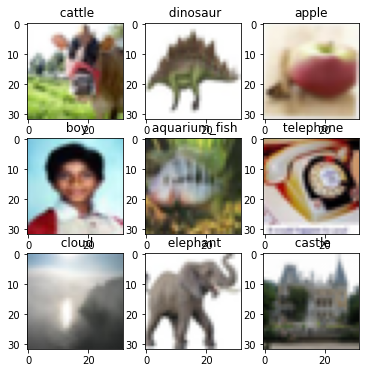

In [58]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

### Αντιστοίχιση κλάσεων στο εύρος [0,79]

Aρχικά,τα δεδομένα μας έχουν ως labels αριθμούς στο έυρος [0,99].Τα νευρωνικά μας δίκτυο είναι αναγκασμένα να έχουν στο επίπεδο εξόδου 100 νευρώνες,ενώ έχουμε 80 κλάσεις.Για να παρακάμψουμε αυτό το πρόβλημα αντιστοιχίζουμε κάθε κλάση σε αριθμούς στο εύρος [0,79].

In [59]:
# --------------------------------------------------------------------------------------------------------------------------------#
# Τα labels μας έχουν αριθμούς από το 0 έως το 99,όμως έχουμε μόνο 20 labels και όχι 100.Συνεπώς θέλουμε να αλλάξουμε τις τιμές  #
# έτσι ώστε να περιέχουν τιμές από το 0 έως το 79.Αν δεν κάναμε αυτό το mapping το νευρωνικό θα έπρεπε να έχει 100 νευρώνες      #
#                      στην τελευταίο layer,ενώ τώρα μπορούμε να χρησιμοποιήσουμε 20.                                            #
# --------------------------------------------------------------------------------------------------------------------------------#

# let's check the size of our labels
print("Train Labels shape:  ",y_train.shape)
print("Test  Labels shape:  ",y_test.shape)

# Create a 2-d array where 0->value1,  1->value2 etc
index = np.array([[x for x in range(80)],[0 for y in range(80)]])

# Let's find out which labels are missing (=0).We count the number of occurences
# We have 20 numbers in range(100),and we want to find these numbers
f = []
for i in range(100):
  f.append(0)
f = np.asarray(f)

for i in range(34000):
  f[y_train[i]]+=1

print("\nOccurences of label's numbers :\n",f)

# Append the numbers in the 2-d array "index",and prin the array
index_before = []
for i  in range(100):
  if (f[i]!=0):
    index_before.append(i)

index[1] = index_before
d = dict((j, index[i][j]) for i in range(len(index)) for j in range(len(index[0])))
print("\nOur mapping will be:\n",d)

#-----------------------------------------------#
#               Apply the mapping               #
#-----------------------------------------------#

# function to return key for any value 
def get_key(val): 
    for key, value in d.items(): 
         if val == value: 
             return key 

# map train labels
val = 0
for i in range(34000):
  val = get_key(y_train[i])
  y_train[i] = val 

# repeat for test labels
val = 0
for i in range(8000):
  val = get_key(y_test[i])
  y_test[i] = val 
#-----------------------------------------------#
#               Check results                   #
#-----------------------------------------------#
print("\nOur labels after the mapping:")
print("\nTrain Labels \n",y_train)
print("\nTest Labels  \n",y_test)

Train Labels shape:   (34000, 1)
Test  Labels shape:   (8000, 1)

Occurences of label's numbers :
 [428 417 430 422 421 418 424 424 440 427 410 417 421 417 439 406 442 433
 436 440 421   0   0 420 417 414   0 425   0 414 435 434 441 425 436 425
 428 417 423   0 436 425   0 432 420 426 412   0 418   0 411 413 414   0
 433 418 422 423   0 443   0 427 431 425   0 423 432 438 429 441 438 434
 433 430 417 417   0 420 430 421 418 437   0 422 419   0 408 420   0   0
   0 420 431 430   0 408   0 410 427 431]

Our mapping will be:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 23, 22: 24, 23: 25, 24: 27, 25: 29, 26: 30, 27: 31, 28: 32, 29: 33, 30: 34, 31: 35, 32: 36, 33: 37, 34: 38, 35: 40, 36: 41, 37: 43, 38: 44, 39: 45, 40: 46, 41: 48, 42: 50, 43: 51, 44: 52, 45: 54, 46: 55, 47: 56, 48: 57, 49: 59, 50: 61, 51: 62, 52: 63, 53: 65, 54: 66, 55: 67, 56: 68, 57: 69, 58: 70, 59: 71, 60: 72, 61

In [60]:
s=set()
for x in y_train:
  for y in x:
    if (y<0 or y>80):
      print("Value Error")
      break
    s.add(y)

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print("\nNumber of classes=",len(s))

Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)

Number of classes= 80


## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [14]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 50, 200, 100)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_16 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)              

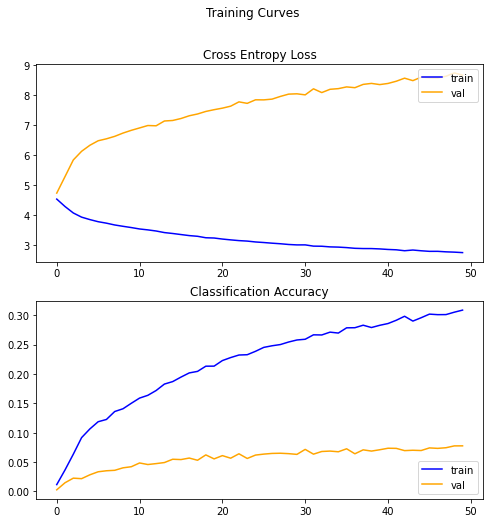


Test set evaluation metrics
30/30 [==============================] - 0s 5ms/step - loss: 2.9282 - accuracy: 0.2703
loss: 2.93
accuracy: 0.27


In [ ]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

### Μεταφορά μάθησης: VGG16

In [ ]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  vgg_model=tf.keras.applications.VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')
  
  VGG16_MODEL=vgg_model.layers[0](vgg_model)

  # unfreeze conv layers
  VGG16_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 25, 40, 10)

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 5s 67ms/step - loss: 4.8226 - accuracy: 0.0126 - val_loss: 4.4626 - val_accuracy: 0.0383
Epoch 2/25
40/40 [================

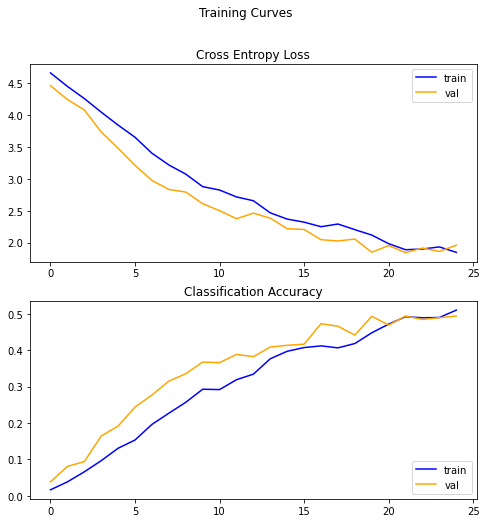


Test set evaluation metrics
28/28 [==============================] - 1s 18ms/step - loss: 1.8823 - accuracy: 0.4911
loss: 1.88
accuracy: 0.49


In [ ]:
model_report(VGG16_MODEL, VGG16_MODEL_history, 28)

# Βελτίωση της επίδοσης με πειράματα

Καλείστε να βελτιώσετε τα αποτελέσματα ταξινόμησης στο CIFAR-100 και να βγάλατε συμπεράσματα, σύμφωνα με όσα ζητούνται σε σχέση με την αναφορά παράδοσης. 

---

## Δοκιμές διαφορετικών μοντέλων

Μπορείτε είτε να δοκιμάσετε μοντέλα "from scratch", όπου ορίζετε την αρχιτεκτονική του δικτύου όπως θέλετε, είτε να χρησιμοποιήσετε μεταφορά μάθησης.

---


### Μοντέλα "from scratch"


#### 1ο Μοντέλο 

Επεκτείνουμε το "simple_model".Ακολουθεί περιγραφή των επιλογών σχεδίασης


*   Η ReLU δεν λαμβάνει αρνητικές τιμές, με αποτέλεσμα τη θετική ενεργοποίηση, δημιουργώντας bias στα επόμενα επίπεδα. Οι ELUs επιτρέπουν αρνητικές τιμές, φέρνοντας τη μέση ενεργοποίηση πλησιέστερα στο μηδέν διορθώνοντας το bias. 
*   Χρησιμοποιήθηκε pooling και dropout για την ελαχιστοποιηση του φαινομένου overfitting.



In [ ]:
def init_model_1(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.Conv2D(128, (3, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(256, (3, 3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.Conv2D(256, (3, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(512, (3, 3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.Conv2D(512, (3, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=(4, 4)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(80))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(), 
                loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=["accuracy"])

  if summary: 
    model.summary()
  return model


In [ ]:
SIMPLE_MODEL = init_model_1(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 100, 30, 5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0

In [ ]:
SIMPLE_MODEL = init_model_1(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 100, 30, 5)

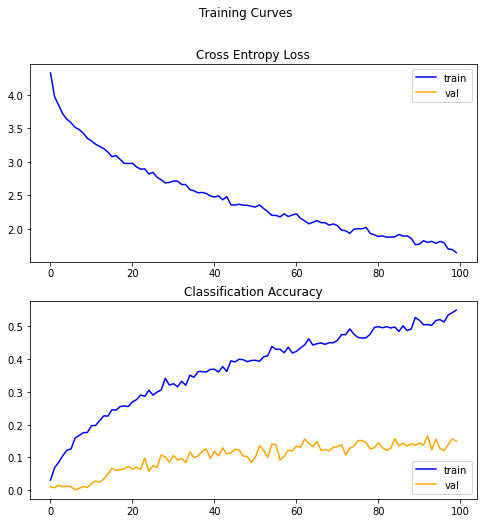


Test set evaluation metrics
30/30 [==============================] - 0s 5ms/step - loss: 3.8042 - accuracy: 0.1128
loss: 3.80
accuracy: 0.11


In [ ]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

Παρατηρείται πολύ έντονο το φαινόμενο overfitting,πράγμα που θα προσπαθήσουμε να βελτιώσουμε στα επόμενα βήματα.

#### 2o μοντέλο

Θα προπονήσουμε το δίκτυο κάνοντας χρήση ΤΡU στο Collab προκειμένου να επιτύχουμε γρήγορη εκπαίδευση.Για το λόγω αυτό είναι απαραίτητο να τρέξουμε το παρακάτω κελί κώδικα.

In [ ]:
# A function in order to connect to colab's TPU
TPU()

Tensorflow version 2.4.0
Running on TPU  ['10.43.62.146:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.43.62.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.43.62.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_val = to_categorical(y_val, 100)

In [ ]:
train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

In [ ]:
def init_model_2(summary):
  weight_decay = 0.0005

  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same',
              input_shape=[32,32,3],kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dense(100))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

  if summary:
    model.summary()
  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model_2 = init_model_2(True)
model_2_history = model_2.fit(train_ds,
                           batch_size=BATCH_SIZE, 
                           epochs=20,
                           steps_per_epoch=1000,
                           validation_data=validation_ds,
                           validation_steps=50,
                           verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)       

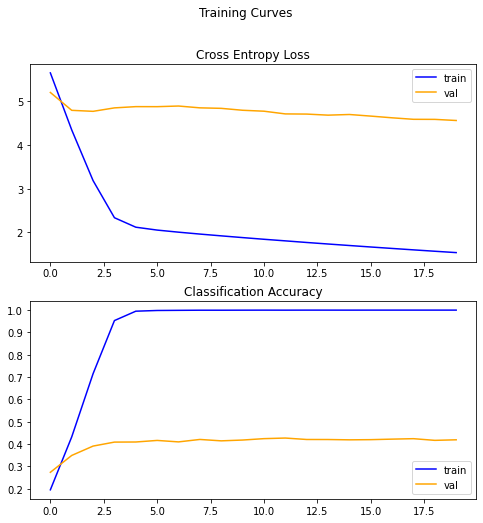


Test set evaluation metrics
100/100 [==============================] - 3s 24ms/step - loss: 4.4859 - accuracy: 0.4299
loss: 4.49
accuracy: 0.43


In [ ]:
model_report(model_2, model_2_history, 100)

### Μεταφορά μάθησης



#### ResNet50V2

Αρχικά φέρνουμε το προ-εκπαιδευμένο μοντέλο, διατηρώντας μόνο τη συνελικτική του βάση.Στην κεφαλή ορίζουμε 2 επίπεδα ταξινόμησης.Ως παραμετρο "trainable" καθορίζουμε εάν η συνελικτική βάση θα είναι προ-εκπαιδευμένη ή οχι.

In [ ]:
def init_RESNET_model(trainable, summary):
  ResNetModel=app.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, img_channels), classes=20)

  # No training to ResNet model as it is already trained
  ResNetModel.trainable=trainable

  dropout_layer1 = layers.Dropout(rate = 0.3)
  dropout_layer2 = layers.Dropout(rate = 0.5)
  global_average_layer = layers.GlobalAveragePooling2D()
  batch_layer = layers.BatchNormalization()
  # classification layers
  prediction_layer1 = layers.Dense(512,activation='elu')
  prediction_layer2 = layers.Dense(100,activation='softmax')

  # Define model's architecture
  model = Sequential([ResNetModel, 
                      dropout_layer1, 
                      global_average_layer,
                      prediction_layer1,
                      batch_layer,
                      dropout_layer2, 
                      prediction_layer2
                      ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Αρχικά εκπαιδεύουμε το δίκτυο με την συνελικτική βάση προεκπαιδευμένη.

In [ ]:
RESNET = init_RESNET_model(trainable=False, summary = True)
%time RESNET_history = train_model(RESNET, 200, 40, 10)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout_34 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)             

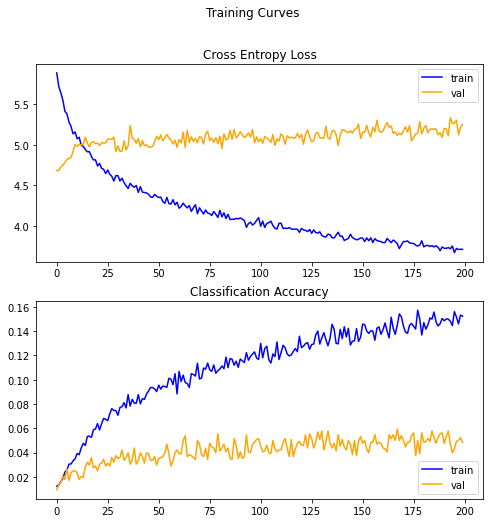


Test set evaluation metrics
200/200 [==============================] - 78s 385ms/step - loss: 3.6545 - accuracy: 0.1704
loss: 3.65
accuracy: 0.17


In [ ]:
model_report(RESNET,RESNET_history,200)

Παρατηρείται έντονο το φαινόμενο της υπερπροσαρμογής.Στo κεφάλαιο της βελτιστοποίησης θα προσπαθήσουμε να βελτιώσουμε την απόδοση.

Στη συνέχεια εκπαιδεύουμε ολόκληρο το δίκτυο.Επιλέγουμε χαμηλότερο αριθμό epochs για προφανής λόγους.

In [ ]:
RESNET_trainable = init_RESNET_model(trainable=True, summary = True)
%time RESNET_trainable_history = train_model(RESNET_trainable, 50, 40, 10)

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

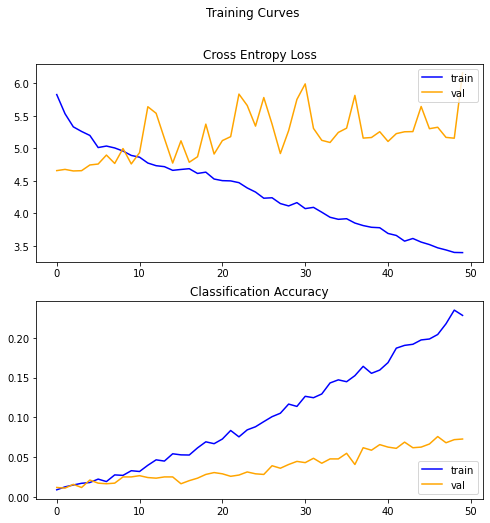


Test set evaluation metrics
200/200 [==============================] - 80s 399ms/step - loss: 3.2516 - accuracy: 0.2630
loss: 3.25
accuracy: 0.26


In [ ]:
model_report(RESNET_trainable,RESNET_trainable_history,200)

In [ ]:
RESNET_trainable.save("drive/My Drive/colab_sessions/RESNET_trainable")

INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/RESNET_trainable/assets


#### EfficientNet

Αρχικά εγκαθιστούμε το EfficientNet

In [ ]:
!pip install -U efficientnet

Θα προπονήσουμε το δίκτυο κάνοντας χρήση ΤΡU στο Collab προκειμένου να επιτύχουμε γρήγορη εκπαίδευση.Για το λόγω αυτό είναι απαραίτητο να τρέξουμε το παρακάτω κελί κώδικα.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.0
Running on TPU  ['10.69.159.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.69.159.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.159.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Κάνουμε resize τα δεδομένα μας καθώς το δίκτυο απαίτει εικόνες (224,224,3) ως είσοδο

In [ ]:
size=224

x_train_resized = tf.image.resize(x_train, (size, size))
x_val_resized = tf.image.resize(x_val, (size, size))
x_test_resized = tf.image.resize(x_test, (size, size))

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_val = to_categorical(y_val, 100)

In [ ]:
train_ds =_input_fn(x_train_resized,y_train, batch_size) #PrefetchDataset object
validation_ds =_input_fn(x_val_resized,y_val, batch_size) #PrefetchDataset object
test_ds =_input_fn(x_test_resized,y_test, batch_size) #PrefetchDataset object

Αποκοκόπτουμε την κεφαλή του μοντέλου

In [ ]:
import efficientnet.keras as efn 

def create_model(summary):
  efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = 100, input_shape = input_shape)

  model = Sequential()
  model.add(efnb0)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(100, activation = 'softmax'))

  sgd = SGD()
  es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
  rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)
  model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])
  
  if summary:
    model.summary()
  return model

Θα το προπονήσουμε με ΤPU για ταχύτερη εκπαίδευση

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  efficientnet = create_model(True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
efficientnet_history = efficientnet.fit(train_ds,validation_data = validation_ds, 
                          steps_per_epoch = 1000,
                          validation_steps=50,
                           epochs = 30, 
                           verbose = 1)

efficientnet.save_weights(path+"efficient_net.h5")

Epoch 1/30
1000/1000 [==============================] - 111s 49ms/step - loss: 4.5425 - acc: 0.0140 - val_loss: 4.5901 - val_acc: 0.0150
Epoch 2/30
1000/1000 [==============================] - 43s 43ms/step - loss: 4.4211 - acc: 0.0154 - val_loss: 4.5581 - val_acc: 0.0100
Epoch 3/30
1000/1000 [==============================] - 43s 43ms/step - loss: 4.3898 - acc: 0.0177 - val_loss: 4.5768 - val_acc: 0.0150
Epoch 4/30
1000/1000 [==============================] - 43s 43ms/step - loss: 4.3581 - acc: 0.0300 - val_loss: 4.7194 - val_acc: 0.0275
Epoch 5/30
1000/1000 [==============================] - 42s 42ms/step - loss: 4.3091 - acc: 0.0559 - val_loss: 5.4664 - val_acc: 0.0450
Epoch 6/30
1000/1000 [==============================] - 42s 42ms/step - loss: 4.2173 - acc: 0.0838 - val_loss: 4.8407 - val_acc: 0.0650
Epoch 7/30
1000/1000 [==============================] - 43s 43ms/step - loss: 4.0843 - acc: 0.1087 - val_loss: 4.1853 - val_acc: 0.0525
Epoch 8/30
1000/1000 [=========================

#### Xception

In [ ]:
x_train_resized = tf.image.resize(x_train, (71, 71))
x_val_resized = tf.image.resize(x_val, (71, 71))
x_test_resized = tf.image.resize(x_test, (71, 71))

In [ ]:
train_ds =_input_fn(x_train_resized,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val_resized,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test_resized,y_test, BATCH_SIZE) #PrefetchDataset object

In [ ]:
def init_Xception_model(summary):
  Xception_MODEL = keras.applications.xception.Xception(include_top=False, weights='imagenet', 
                                                        input_shape=(71, 71, 3), classes=80)

  Xception_MODEL.trainable=True

  model = tf.keras.Sequential([Xception_MODEL, 
                               Dropout(rate = 0.2), 
                               GlobalAveragePooling2D(), 
                               Dense(80, activation='softmax')])

  model.compile(optimizer=Adam(learning_rate=0.00005), 
                loss=sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                163920    
Total params: 21,025,400
Trainable params: 20,970,872
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/20
100/100 [==============================] - 40s 280ms/step - loss: 4.2622 - accuracy: 0.0466 - val_loss: nan - val_accuracy: 0.0758
Epoch 2/20
100/100 [==============================] - 28s 276ms/step - loss: 3.3658 - accuracy:

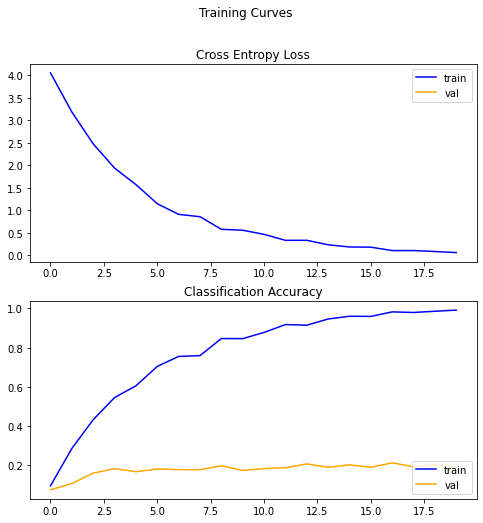


Test set evaluation metrics
40/40 [==============================] - 3s 66ms/step - loss: 1.0850 - accuracy: 0.7264
loss: 1.08
accuracy: 0.73


In [ ]:
Xception_MODEL = init_Xception_model(summary = True)
Xception_MODEL_history = train_model(Xception_MODEL, 20, 100, 10)
model_report(Xception_MODEL, Xception_MODEL_history, 100)

#### ΒiT-L

Mπορούμε να επιλέξουμε τα μοντέλα s και m.Tα πρώτα ειναι εκπαιδευμένα πάνω στο ImageNet-1k, ενώ τα δεύτερα στο ImageNet-21k.Oι παραλαγές που μας παρέχει το BiT είναι: R50x1, R50x3, R101x1, R101x3 and R152x4.Το R σημαίνει σημαίνει ResNet.Δηλαδή R50x1 = ResNet50 μεγέθους 1.To R50x3 σημαίνει ResNet50 3 φορές μεγαλύτερο από το x1.Αντίστοιχα και για τα υπόλοιπα μοντέλα.

Επιλέγουμε ενα ResNet-50 pre-trained στο ImageNet-21k για να χρησιμοποιήσουμε στην άσκησή μας.

In [16]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x3/1"
r50x3 = hub.KerasLayer(model_url)

In [16]:
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]
# Define optimiser and loss

# from keras.callbacks import LearningRateScheduler
# lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

lr = 0.003 * BATCH_SIZE / 128 
# # Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)


def init_BiT(summary, module):
  model = MyBiTModel(num_classes=100, module=module)
  model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
  if (summary):
    model.summary()
  return model

In [19]:
model = init_BiT(False, module= r50x3)

# Fine-tune model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    steps_per_epoch=1000,
    epochs= 20,  
    validation_data=validation_ds,
    validation_steps=30
)

Epoch 1/20
1000/1000 [==============================] - 172s 154ms/step - loss: 2.7832 - accuracy: 0.4227 - val_loss: 10.3313 - val_accuracy: 0.1133
Epoch 2/20
1000/1000 [==============================] - 158s 158ms/step - loss: 1.4570 - accuracy: 0.6126 - val_loss: 10.3024 - val_accuracy: 0.1128
Epoch 3/20
1000/1000 [==============================] - 160s 160ms/step - loss: 1.4420 - accuracy: 0.6154 - val_loss: 10.3573 - val_accuracy: 0.1201
Epoch 4/20
1000/1000 [==============================] - 161s 161ms/step - loss: 1.4158 - accuracy: 0.6213 - val_loss: 10.2480 - val_accuracy: 0.1117
Epoch 5/20
1000/1000 [==============================] - 161s 161ms/step - loss: 1.4171 - accuracy: 0.6214 - val_loss: 10.2522 - val_accuracy: 0.1135
Epoch 6/20
1000/1000 [==============================] - 161s 161ms/step - loss: 1.4070 - accuracy: 0.6230 - val_loss: 10.2342 - val_accuracy: 0.1146
Epoch 7/20
1000/1000 [==============================] - 161s 161ms/step - loss: 1.4079 - accuracy: 0.6217 

Model: "my_bi_t_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  614500    
_________________________________________________________________
keras_layer (KerasLayer)     multiple                  211174080 
Total params: 211,788,580
Trainable params: 614,500
Non-trainable params: 211,174,080
_________________________________________________________________


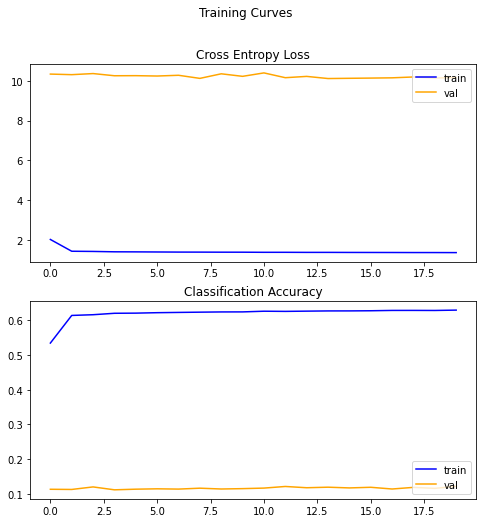


Test set evaluation metrics
200/200 [==============================] - 29s 145ms/step - loss: 2.2681 - accuracy: 0.4530
loss: 2.27
accuracy: 0.45


In [24]:
model.summary()
model_report(model, history, 200)

Πηγές:



*   [Tensorflow article](https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html) 

*   [Notebook](https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb#scrollTo=GXY0spPLdxkX)



## Βελτιστοποίηση

### Διαχείριση μνήμης (TFRecord)



In [ ]:
# Reference: https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_array(array):
  """Serialize x_train instances"""
  array = tf.io.serialize_tensor(array)
  return array

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
#-------------------------------------------------------------#
#        Write TFRecord files for training data               #
#-------------------------------------------------------------#
size = 300
train_path = list()
for i in range(0,int(len(x_train)/size)):
  train_path.append('train_{}.tfrecords'.format(i))
  with tf.io.TFRecordWriter(train_path[i]) as writer:
    for array, label in zip(x_train[size*i:size*(i+1)], y_train[size*i:size*(i+1)]):
      serialized_array = serialize_array(array)
      feature = {'b_feature': _bytes_feature(serialized_array), 'label': _int64_feature(label)} 
      example_message = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example_message.SerializeToString())

#-------------------------------------------------------------#
#        Write TFRecord files for validation data             #
#-------------------------------------------------------------#
val_path = list()
for i in range(0,int(len(x_val)/size)):
  val_path.append('val_{}.tfrecords'.format(i))
  with tf.io.TFRecordWriter(val_path[i]) as writer:
    for array, label in zip(x_val[size*i:size*(i+1)], y_val[size*i:size*(i+1)]):
      serialized_array = serialize_array(array)
      feature = {'b_feature': _bytes_feature(serialized_array), 
               'label': _int64_feature(label)} 
      example_message = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example_message.SerializeToString())

#-------------------------------------------------------------#
#        Write TFRecord files for test data                   #
#-------------------------------------------------------------#
test_path = list()
for i in range(0,int(len(x_test)/size)):
  test_path.append('test_{}.tfrecords'.format(i))
  with tf.io.TFRecordWriter(test_path[i]) as writer:
    for array, label in zip(x_test[size*i:size*(i+1)], y_test[size*i:size*(i+1)]):
      serialized_array = serialize_array(array)
      feature = {'b_feature': _bytes_feature(serialized_array), 
               'label': _int64_feature(label)} 
      example_message = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example_message.SerializeToString())

In [ ]:
#------------------------------------------#
#      TFRecord file decoding              #
#------------------------------------------#
def _parse_tfr_element(element):
  parse_dic = { 'b_feature': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
                'label': tf.io.FixedLenFeature([], tf.int64)}
  example_message = tf.io.parse_single_example(element, parse_dic)

  b_feature = example_message['b_feature'] # get byte string
  label = tf.cast(example_message['label'], tf.int64)
  feature = tf.io.parse_tensor(b_feature, out_type=tf.float64) # restore Multi-Dimensional array from byte string

  feature.set_shape((32, 32, 3))  # shapes are not stored, so they must be set manually
  label.set_shape(())

  return feature, label

Πηγή:
* https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord


### Xρόνοι εκπαίδευσης

#### Τεχνικές μείωσης χρόνου

Απαραίτητες ρυθμίσεις για τις συναρτήσεις

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

##### Simple

Στη συνάρτηση '_input_fn_2_simple':
*  Μετατρέπουμε το dataset σε TFRecords




In [ ]:
def _input_fn_2_simple(path, BATCH_SIZE):
  ds = tf.data.TFRecordDataset(path)  
  ds = ds.map(_parse_tfr_element) # Read TFRecord file
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  return ds

##### Parallel Read

Στη συνάρτηση '_input_fn_3_par':
*  Μετατρέπουμε το dataset σε TFRecords
*  Ορίζουμε παράλληλη ανάγνωση στα δεδομένα μας



In [ ]:
def _input_fn_3_par(path, BATCH_SIZE):
  ds = tf.data.Dataset.list_files(path)  
  ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(AUTOTUNE),
                           cycle_length=4, block_length=4, num_parallel_calls=AUTOTUNE)
  ds = ds.map(_parse_tfr_element, num_parallel_calls=AUTOTUNE) # Read TFRecord file
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  return ds

##### Prefetching

Στη συνάρτηση '_input_fn_4_pref':
*  Μετατρέπουμε το dataset σε TFRecords
*  Χρησιμοποιούμε την ιδιότητα data prefetch του tf2 



In [ ]:
def _input_fn_4_pref(path, BATCH_SIZE):
  ds = tf.data.TFRecordDataset(path)  
  ds = ds.map(_parse_tfr_element) # Read TFRecord file
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

##### Parallel Calls

Στη συνάρτηση '_input_fn_5_par_calls':
*  Μετατρέπουμε το dataset σε TFRecords
* Χρησιμοποιούμε την ιδιότητα parallel_calls της map για να εφαρμόζουμε τον parser ταυτόχρονα σε πολλά δεδομένα.


In [ ]:
def _input_fn_5_par_calls(path, BATCH_SIZE):
  ds = tf.data.TFRecordDataset(path)
  ds = ds.map(_parse_tfr_element, num_parallel_calls=AUTOTUNE) # Read TFRecord file
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  return ds

##### Caching

Στη συνάρτηση '_input_fn_6_cache':
*  Μετατρέπουμε το dataset σε TFRecords
*  Χρησιμοποιύμε caching

In [ ]:
def _input_fn_6_cache(path, BATCH_SIZE):
  ds = tf.data.TFRecordDataset(path)
  ds = ds.map(_parse_tfr_element) # Read TFRecord file
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  return ds

##### Change order

Στη συνάρτηση '_input_fn_7_order':
*  Μετατρέπουμε το dataset σε TFRecords
*  Eναλλάσουμε τη θέση των shuffle και repeat προκειμένου το 2ο να πραγματοποιείται πρώτα.

In [ ]:
def _input_fn_7_order(path, BATCH_SIZE):
  ds = tf.data.TFRecordDataset(path)  
  ds = ds.map(_parse_tfr_element) # Read TFRecord file
  ds = ds.repeat()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.batch(BATCH_SIZE)
  return ds

##### All together

Στη συνάρτηση '_input_fn_8_all':
*  Μετατρέπουμε το dataset σε TFRecords
*  Ορίζουμε παράλληλη ανάγνωση στα δεδομένα μας
*  Χρησιμοποιύμε caching
*  Χρησιμοποιούμε την ιδιότητα data prefetch του tf2 
* Χρησιμοποιούμε την ιδιότητα parallel_calls της map για να εφαρμόζουμε τον parser ταυτόχρονα σε πολλά δεδομένα.



In [ ]:
def _input_fn_8_all(path, BATCH_SIZE):
  ds = tf.data.Dataset.list_files(path)  
  ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(AUTOTUNE),
                           cycle_length=4, block_length=4, num_parallel_calls=AUTOTUNE)
  ds = ds.map(_parse_tfr_element, num_parallel_calls=AUTOTUNE) # Read TFRecord file
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

##### Parallel Read - 2 -optimization

Στη συνάρτηση '_input_fn_9_par_2':
*  Μετατρέπουμε το dataset σε TFRecords
*  Ορίζουμε παράλληλη ανάγνωση στα δεδομένα μας,αυτή τη φορά όμως με cycle_lenth=8 και block_length = 8
* Oι υπερπαράμεροι θα δίνονται ως είσοδος στη συνάρτηση, καθώς θα αναζητήσουμε καλές τιμές για αυτές.



In [ ]:
def _input_fn_9_par_2(path, BATCH_SIZE, cl, bl):
  ds = tf.data.Dataset.list_files(path)  
  ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(AUTOTUNE),
                           cycle_length=cl, block_length=bl, num_parallel_calls=AUTOTUNE)
  ds = ds.map(_parse_tfr_element, num_parallel_calls=AUTOTUNE) # Read TFRecord file
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  return ds

##### All together - 2

Στη συνάρτηση '_input_fn_10_all_2':
*  Μετατρέπουμε το dataset σε TFRecords
*  Ορίζουμε παράλληλη ανάγνωση στα δεδομένα μας
*  Χρησιμοποιύμε caching
*  Χρησιμοποιούμε την ιδιότητα data prefetch του tf2 
* Χρησιμοποιούμε την ιδιότητα parallel_calls της map για να εφαρμόζουμε τον parser ταυτόχρονα σε πολλά δεδομένα.



In [ ]:
def _input_fn_10_all_2(path, BATCH_SIZE):
  ds = tf.data.Dataset.list_files(path)  
  ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x).prefetch(AUTOTUNE),
                           cycle_length=AUTOTUNE, block_length=8, num_parallel_calls=AUTOTUNE)
  ds = ds.map(_parse_tfr_element, num_parallel_calls=AUTOTUNE) # Read TFRecord file
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#### Simple Model

Θα εκπαιδεύσουμε το απλό συνελικτικό δίκτυο που μας δόθηκε από την εκφώνηση για όλες τις input functions που κατασκευάσαμε προηγουμένως και θα συγκρίνουμε τους χρόνους εκπαίδευσης 

In [ ]:
tr = [_input_fn_2_simple(train_path, BATCH_SIZE), _input_fn_3_par(train_path, BATCH_SIZE),   _input_fn_4_pref(train_path, BATCH_SIZE), _input_fn_5_par_calls(train_path, BATCH_SIZE),
      _input_fn_6_cache(train_path, BATCH_SIZE),  _input_fn_7_order(train_path, BATCH_SIZE), _input_fn_8_all(train_path, BATCH_SIZE)]

val = [_input_fn_2_simple(val_path, BATCH_SIZE), _input_fn_3_par(val_path, BATCH_SIZE),   _input_fn_4_pref(val_path, BATCH_SIZE), _input_fn_5_par_calls(val_path, BATCH_SIZE),
      _input_fn_6_cache(val_path, BATCH_SIZE),   _input_fn_7_order(val_path, BATCH_SIZE), _input_fn_8_all(val_path, BATCH_SIZE)]

tes = [_input_fn_2_simple(test_path, BATCH_SIZE), _input_fn_3_par(test_path, BATCH_SIZE),   _input_fn_4_pref(test_path, BATCH_SIZE), _input_fn_5_par_calls(test_path, BATCH_SIZE),
      _input_fn_6_cache(test_path, BATCH_SIZE),   _input_fn_7_order(test_path, BATCH_SIZE), _input_fn_8_all(test_path, BATCH_SIZE)]

In [ ]:
SIMPLE_MODEL = init_simple_model(summary = False)
history = []
training_time = []
m = len(tr)
for x in range(m):
  print(x+2,"\n")

  start = time.time()
  %time history.append( SIMPLE_MODEL.fit(tr[x], epochs=30, steps_per_epoch=50, validation_data=val[x], validation_steps=20))
  end = time.time()
  SIMPLE_MODEL.save("drive/My Drive/colab_sessions/SIMPLE_MODEL_"+str(x+2))
  training_time.append(end-start)


2 

Epoch 1/30
50/50 [==============================] - 17s 251ms/step - loss: 4.6024 - accuracy: 0.0135 - val_loss: 4.5948 - val_accuracy: 0.0098
Epoch 2/30
50/50 [==============================] - 11s 214ms/step - loss: 4.5683 - accuracy: 0.0125 - val_loss: 4.6176 - val_accuracy: 0.0043
Epoch 3/30
50/50 [==============================] - 11s 217ms/step - loss: 4.5205 - accuracy: 0.0152 - val_loss: 4.6475 - val_accuracy: 0.0168
Epoch 4/30
50/50 [==============================] - 11s 213ms/step - loss: 4.4590 - accuracy: 0.0254 - val_loss: 4.7418 - val_accuracy: 0.0109
Epoch 5/30
50/50 [==============================] - 11s 212ms/step - loss: 4.3635 - accuracy: 0.0452 - val_loss: 4.8002 - val_accuracy: 0.0074
Epoch 6/30
50/50 [==============================] - 11s 212ms/step - loss: 4.3008 - accuracy: 0.0457 - val_loss: 4.9774 - val_accuracy: 0.0039
Epoch 7/30
50/50 [==============================] - 11s 213ms/step - loss: 4.2138 - accuracy: 0.0514 - val_loss: 5.1177 - val_accuracy: 0.

O χρόνος εκπαίδευσης για την parallel calls στρατηγική ήταν ανεξήγητα υψηλός,συνεπώς αποφασίσαμε να αναζητήσουμε κάποιες καλές τιμές για τις υπερπαραμέτρους cycle_length και block_length

In [ ]:
#-----------------------------------------------#
#  Search for cycle length and block length     #
#-----------------------------------------------#
SIMPLE_MODEL = init_simple_model(summary = False)
par_2_history=[]
training_time=[]
for cl in range(1,15):
  for bl in range(1,15):
    train_ds =_input_fn_9_par_2(train_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object
    validation_ds =_input_fn_9_par_2(val_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object
    test_ds =_input_fn_9_par_2(test_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object

    print("clock_cycle = ",cl," block_size = ",bl,"\n")

    start = time.time()
    %time par_2_history.append( SIMPLE_MODEL.fit(train_ds, epochs=5, steps_per_epoch=20, validation_data=validation_ds,validation_steps=5))
    end = time.time()
    SIMPLE_MODEL.save("drive/My Drive/colab_sessions/SIMPLE_MODEL_9_cl="+str(cl)+"_bl="+str(bl))
    training_time.append(end-start)

clock_cycle =  1  block_size =  1 

Epoch 1/5
20/20 [==============================] - 9s 263ms/step - loss: 4.6028 - accuracy: 0.0117 - val_loss: 4.5986 - val_accuracy: 0.0203
Epoch 2/5
20/20 [==============================] - 5s 258ms/step - loss: 4.5919 - accuracy: 0.0109 - val_loss: 4.5961 - val_accuracy: 0.0125
Epoch 3/5
20/20 [==============================] - 5s 241ms/step - loss: 4.5706 - accuracy: 0.0189 - val_loss: 4.6041 - val_accuracy: 0.0063
Epoch 4/5
20/20 [==============================] - 5s 239ms/step - loss: 4.5459 - accuracy: 0.0158 - val_loss: 4.6172 - val_accuracy: 0.0188
Epoch 5/5
20/20 [==============================] - 5s 231ms/step - loss: 4.5381 - accuracy: 0.0131 - val_loss: 4.5950 - val_accuracy: 0.0109
CPU times: user 42.4 s, sys: 7.72 s, total: 50.1 s
Wall time: 27.9 s
INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/SIMPLE_MODEL_9_cl=1_bl=1/assets
clock_cycle =  1  block_size =  2 

Epoch 1/5
20/20 [==============================] - 8s 242

Στη συνέχεια βρίσκουμε τις τιμές που έδωσαν τον λιγότερο χρόνο. Στη συνέχεια θα ξανατρέξουμε το SIMPLE_MODEL για κάποιες από αυτές τις τιμές και αριθμό epochs ίσο με αυτόν που είχαμε προηγουμένως (30) ώστε να βρούμε τον καλύτερο συνδυασμό των υπερ-παραμέτρων.

In [ ]:
good_values=[]
cnt=0
for x in training_time:
  cnt+=1
  if x<28:
    good_values.append((cnt,x))
print(good_values)

[(1, 27.85248613357544), (2, 27.538084983825684), (4, 27.64676070213318), (5, 27.327426433563232), (7, 27.38368272781372), (9, 27.59616994857788), (10, 27.49409246444702), (12, 27.800278902053833), (19, 27.76383352279663), (20, 27.932331800460815), (21, 27.81410002708435), (24, 27.768146991729736)]


In [ ]:
par_2_history=[]
training_time=[]
for cl in [1]:
  for bl in [1,2,4,5,7,9,10,12]:
    train_ds =_input_fn_9_par_2(train_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object
    validation_ds =_input_fn_9_par_2(val_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object
    test_ds =_input_fn_9_par_2(test_path, BATCH_SIZE=BATCH_SIZE, cl=cl, bl=bl) #PrefetchDataset object

    print("clock_cycle = ",cl," block_size = ",bl,"\n")

    start = time.time()
    %time par_2_history.append( SIMPLE_MODEL.fit(train_ds, epochs=30, steps_per_epoch=50, validation_data=validation_ds,validation_steps=20))
    end = time.time()
    training_time.append(end-start)

clock_cycle =  1  block_size =  1 

Epoch 1/30
50/50 [==============================] - 16s 225ms/step - loss: 1.9978 - accuracy: 0.4712 - val_loss: 10.9622 - val_accuracy: 0.0941
Epoch 2/30
50/50 [==============================] - 11s 211ms/step - loss: 1.9938 - accuracy: 0.4695 - val_loss: 11.2574 - val_accuracy: 0.0891
Epoch 3/30
50/50 [==============================] - 10s 204ms/step - loss: 1.9663 - accuracy: 0.4791 - val_loss: 11.5038 - val_accuracy: 0.0906
Epoch 4/30
50/50 [==============================] - 10s 204ms/step - loss: 2.0512 - accuracy: 0.4633 - val_loss: 10.6761 - val_accuracy: 0.1035
Epoch 5/30
50/50 [==============================] - 10s 201ms/step - loss: 2.0218 - accuracy: 0.4561 - val_loss: 11.1224 - val_accuracy: 0.1031
Epoch 6/30
50/50 [==============================] - 10s 202ms/step - loss: 1.9926 - accuracy: 0.4717 - val_loss: 10.9175 - val_accuracy: 0.0969
Epoch 7/30
50/50 [==============================] - 10s 202ms/step - loss: 2.0116 - accuracy: 0.4673

Τον καλύτερο συνδυασμό λαμβάνουμε για clock_cycle =  1 , block_size =  2. Δυστυχώς όμως η απόδοση βελτιώνεται ελάχιστα.Η εκπαίδευση ολοκληρώνεται σε 9min 23s έναντι 9min 53s που λάβαμε χωρίς τη βελτιστοποίηση (διαφορά μόλις 30 δευτερολέπτων).


Στη συνέχεια παραθέτουμε έναν ακόμη πειραματισμούς

In [ ]:
tr = _input_fn_10_all_2(train_path, BATCH_SIZE)
val = _input_fn_10_all_2(val_path, BATCH_SIZE)
tes = _input_fn_10_all_2(test_path, BATCH_SIZE)



start = time.time()
%time history= SIMPLE_MODEL.fit(tr, epochs=30, steps_per_epoch=50, validation_data=val, validation_steps=20)
end = time.time()
SIMPLE_MODEL.save("drive/My Drive/colab_sessions/SIMPLE_MODEL_10")
training_time.append(end-start)


Epoch 1/30
50/50 [==============================] - 12s 181ms/step - loss: 1.7178 - accuracy: 0.5412 - val_loss: 12.1017 - val_accuracy: 0.1020
Epoch 2/30
50/50 [==============================] - 8s 163ms/step - loss: 1.7432 - accuracy: 0.5323 - val_loss: 12.0971 - val_accuracy: 0.0988
Epoch 3/30
50/50 [==============================] - 8s 166ms/step - loss: 1.7306 - accuracy: 0.5327 - val_loss: 11.8898 - val_accuracy: 0.1063
Epoch 4/30
50/50 [==============================] - 8s 169ms/step - loss: 1.7459 - accuracy: 0.5311 - val_loss: 11.8915 - val_accuracy: 0.1074
Epoch 5/30
50/50 [==============================] - 8s 167ms/step - loss: 1.7502 - accuracy: 0.5312 - val_loss: 11.9657 - val_accuracy: 0.0965
Epoch 6/30
50/50 [==============================] - 8s 166ms/step - loss: 1.7574 - accuracy: 0.5334 - val_loss: 11.5359 - val_accuracy: 0.1047
Epoch 7/30
50/50 [==============================] - 8s 167ms/step - loss: 1.7194 - accuracy: 0.5337 - val_loss: 11.6928 - val_accuracy: 0.103

### Έλεγχος Υπερπροσαρμογής

#### Dropout

##### Simple Model

In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model_dropout(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 4, 4, 64)        

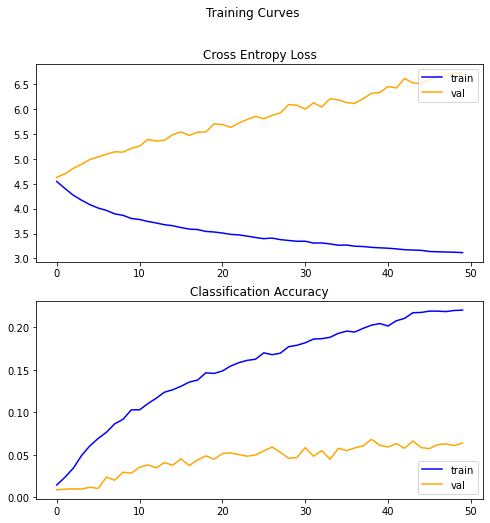


Test set evaluation metrics
200/200 [==============================] - 1s 4ms/step - loss: 3.0147 - accuracy: 0.2624
loss: 3.01
accuracy: 0.26


In [ ]:
SIMPLE_MODEL = init_simple_model_dropout(summary = True)

# Real-time data augmentation:
SIMPLE_MODEL_history = SIMPLE_MODEL.fit(train_ds, 
                                validation_data=validation_ds, 
                                steps_per_epoch=200, 
                                epochs=50, 
                                validation_steps=20)

model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 200)

##### EfficientNet

In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn 

def create_model(summary):
  efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = 100, input_shape = [32,32,3])

  model = Sequential()
  model.add(efnb0)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.4))
  model.add(Dense(100, activation = 'softmax'))

  sgd = SGD()
  model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])
  
  if summary:
    model.summary()
  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  efficientnet = create_model(True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
efficientnet_history_dropout = efficientnet.fit(train_ds,validation_data = validation_ds, 
                          steps_per_epoch = 1000,
                          validation_steps=50,
                           epochs = 30, 
                           verbose = 1)

efficientnet.save_weights(path+"efficient_net_dropout.h5")

Epoch 1/30
1000/1000 [==============================] - 56s 47ms/step - loss: 4.5007 - acc: 0.0138 - val_loss: 4.5876 - val_acc: 0.0150
Epoch 2/30
1000/1000 [==============================] - 40s 40ms/step - loss: 4.4282 - acc: 0.0148 - val_loss: 4.5145 - val_acc: 0.0125
Epoch 3/30
1000/1000 [==============================] - 40s 40ms/step - loss: 4.3923 - acc: 0.0191 - val_loss: 4.5491 - val_acc: 0.0200
Epoch 4/30
1000/1000 [==============================] - 39s 39ms/step - loss: 4.3499 - acc: 0.0295 - val_loss: 7.1089 - val_acc: 0.0275
Epoch 5/30
1000/1000 [==============================] - 41s 41ms/step - loss: 4.2740 - acc: 0.0556 - val_loss: 4.4098 - val_acc: 0.0425
Epoch 6/30
1000/1000 [==============================] - 40s 40ms/step - loss: 4.1717 - acc: 0.0835 - val_loss: 4.3759 - val_acc: 0.0375
Epoch 7/30
1000/1000 [==============================] - 40s 40ms/step - loss: 4.0201 - acc: 0.1129 - val_loss: 4.2081 - val_acc: 0.0650
Epoch 8/30
1000/1000 [==========================

Παρατηρούμε πως το accuracy του μοντέλου έφτασε χαμηλότερες τιμές στη μετρική accuracy συγκριτικά με την εκπαίδευση χωρίς dropout.Αυτό μπορεί να οφείλεται σε 2 πιθανούς παράγοντες:


1.   Η τιμή του Dropout που επιλέξαμε πιθανώς να μην ήταν σωστή, με αποτέλεσμα την πτώση της αποτελεσματικότητας του δικτύου
2.   Στοχαστικοί λόγοι.Ίσως σε αυτήν την εκπαίδευση το μοντέλο να "παγιδεύτηκε" σε ένα κακό τοπικό μέγιστο.



#### Data Augmentation

Θα παρουσιάσουμε 2 τρόπους για επαυξηση δεδομένων.

In [ ]:
# -------------------------------------------------------------------------------------#
#                               Data augmentation                                      #
# -------------------------------------------------------------------------------------#
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1ος Τρόπος
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)
augmented_train_dataset = datagen.flow(x_train, y_train) 

# 2ος τρόπος
# Alternatively we can fit the models on batches with real-time data augmentation.Example:
# model.fit(datagen.flow(x_train, y_train, batch_size=32),
#           steps_per_epoch=len(x_train) / 32, epochs=10)

##### Simple Model

Aπό τις μεθόδους που ορίσαμε στο παραπάνω κελί, επιλέγουμε τη 2η για να εκπαιδεύσουμε το 1ο συνελικτικό δίκτυο που ορίσαμε

In [ ]:
SIMPLE_MODEL = init_simple_model(summary = True)

# Real-time data augmentation:
SIMPLE_MODEL_history = SIMPLE_MODEL.fit(train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                                validation_data=validation_ds, 
                                steps_per_epoch=200, 
                                epochs=50, 
                                validation_steps=20)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)              

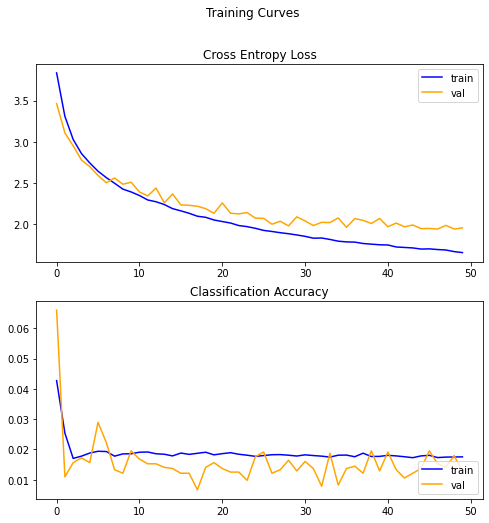


Test set evaluation metrics
199/199 [==============================] - 1s 3ms/step - loss: 1.9128 - accuracy: 0.0153
loss: 1.91
accuracy: 0.02


In [ ]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, len(x_train)/BATCH_SIZE)

##### EfficientNet

Θα εκπαιδεύσουμε ξανα το δίκτυο EfficientNet χρησιμοποιώντας επαύξηση δεδομένων και θα συγκρίνουμε τα αποτελέσματα με τις προηγούμενες εκπαιδεύσεις.

In [ ]:
import cv2
import albumentations as albu
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = BATCH_SIZE,
                 dim = (224, 224), channels = 3, n_classes = 100,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # Generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, 100)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [ ]:
train_generator = DataGenerator(x_train, y_train, augment = True)
valid_generator = DataGenerator(x_val, y_val, augment = False)

In [ ]:
import efficientnet.keras as efn 
import albumentations as albu

def create_model(summary):
  efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = 100, input_shape = [32,32,3])

  model = Sequential()
  model.add(efnb0)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(100, activation = 'softmax'))

  sgd = SGD()
  model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])
  
  if summary:
    model.summary()
  return model

In [ ]:
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
efficientnet_augmentation = create_model(True)

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1, 1, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
efficientnet_augmentation_history = efficientnet_augmentation.fit_generator(train_generator,validation_data = valid_generator, 
                          steps_per_epoch = 1000, validation_steps= 50, epochs = 30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1000/1000 [==============================] - 129s 129ms/step - loss: 3.9659 - acc: 0.1379 - val_loss: 3.6589 - val_acc: 0.1525
Epoch 2/30
1000/1000 [==============================] - 128s 127ms/step - loss: 2.6900 - acc: 0.3430 - val_loss: 1.9209 - val_acc: 0.5125
Epoch 3/30
1000/1000 [==============================] - 129s 129ms/step - loss: 2.1628 - acc: 0.4261 - val_loss: 1.9372 - val_acc: 0.5075
Epoch 4/30
1000/1000 [==============================] - 130s 130ms/step - loss: 1.9255 - acc: 0.4834 - val_loss: 1.3713 - val_acc: 0.6000
Epoch 5/30
1000/1000 [==============================] - 131s 131ms/step - loss: 1.7234 - acc: 0.5272 - val_loss: 1.5951 - val_acc: 0.5650
Epoch 6/30
1000/1000 [==============================] - 132s 132ms/step - loss: 1.6190 - acc: 0.5496 - val_loss: 1.1183 - val_acc: 0.6475
Epoch 7/30
1000/1000 [==============================] - 130s 130ms/step - loss: 1.5489 - acc: 0.5744 - val_loss: 1.0990 - val_acc: 0.6900
Epoch 8/30
1000/1000 [============

NameError: ignored

To error που παρουσιάζεται παραπάνω πρόκειται για ένα άνευ σημασίας ορθογραφικό σε μια εντολή που αποθηκεύει το μοντέλο, η εκπαίδευση πραγματοποιήθηκε κανονικά.

In [ ]:
efficientnet_augmentation.save_weights(path+"EfficientNet_Augmentation.h5")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

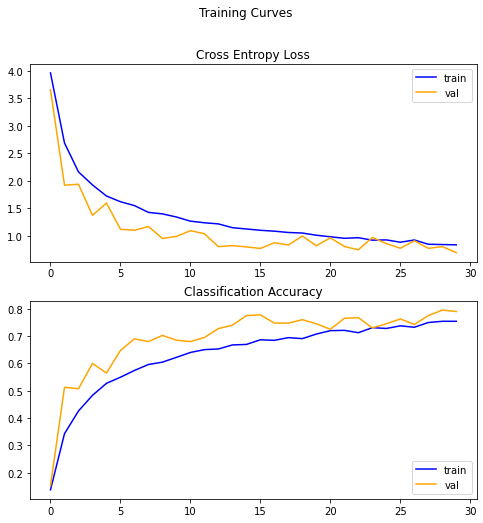

In [ ]:
summarize_diagnostics(efficientnet_augmentation_history)

In [ ]:
print("The Accuracy on the validation data : {:.2f}%".format(100 * efficientnet_augmentation.evaluate_generator(valid_generator, verbose = 1)[-1]))

750/750 [==============================] - 13s 18ms/step - loss: 0.7506 - acc: 0.7865
The Accuracy on the validation data : 78.65%


In [ ]:
# Make sure to set shuffle be False.
test_generator = DataGenerator(x_test, mode = 'predict', augment = False, shuffle = False)
y_pred = efficientnet_augmentation.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

1000/1000 [==============================] - 16s 16ms/step
The accuracy on the testing data : 78.66%


Παρατηρούμε πως το accuracy του δικτύου αυξήθηκε σημαντικά χρησιμοποιώντας την τεχνική της επαύξησης δεδομένων.

Πηγές: 


*   [A detailed example of how to use data generators with Keras
](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
*   [Implementing Custom Data Generators in Keras](https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c)
*  [CIFAR Images classification using CNN
](https://www.kaggle.com/amithasanshuvo/cifar-images-classification-using-cnn)



#### Early Stopping

Ορίζουμε το Εarly Stopping.Επιπλέον θα βάλουμε άλλο ένα callback, το ModelCheckpoint το επιλέγει το καλύτερο μοντέλο στην περίπτωση όπου η εκπαίδευση τερματιστεί με early stopping.

In [ ]:
# Define callbacks 
es = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, mode='max', verbose=1)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

##### Simple Model

In [ ]:
tr = _input_fn(x_train,y_train,BATCH_SIZE)
val = _input_fn(x_val,y_val,BATCH_SIZE)
tes = _input_fn(x_test,y_test,BATCH_SIZE)

In [ ]:
SIMPLE_MODEL = init_simple_model(True)
SIMPLE_MODEL_history =  SIMPLE_MODEL.fit(tr, 
                                         epochs=500, 
                                         steps_per_epoch=1000, 
                                         validation_data=val, 
                                         validation_steps=300, 
                                         callbacks=[es, mc])


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

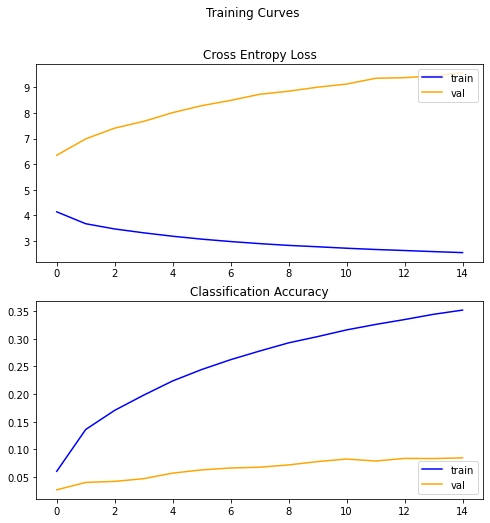


Test set evaluation metrics
1000/1000 [==============================] - 4s 4ms/step - loss: 2.7256 - accuracy: 0.3117
loss: 2.73
accuracy: 0.31


In [ ]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 1000)

To early stopping σταμάτησε το μοντέλο, καθώς όπως βλέπουμε η μετρική validation accuracy σταμάτησε να βελτιώνεται.Πιθανώς πρέπει να ρυθμίσουμε τις παραμέτρους ώστε το early stopping να πραγματοποιείται νωρίτερα, διότι και πάλι βλέπουμε φαινόμενα υπερπροσαρμογής.

### Εύρεση Υπερπαμέτρων (Hyperparameter tuning)

#### Tensorboard

Για την εύρεση υπερπαραμέτρων που επιφέρουν καλή αποτελεσματικότητα χρησιμοποιήθηκε ο κώδικας που παρατίθεται παρακάτω.Ουσιαστικά εκπαιδεύουμε το μοντέλο πολλές φορές και συγκρίνουμε τα αποτελέσματα για κάθε διαφορετικό συνδυασμό υπερπαραμέτρων.Ο συνολικός αριθμός επαναλήψεων καθορίζεται από τον αριθμό των συνδυασμών που προκύπτουν εάν πολλαπλασιάσουμε τον αριθμό loss functions που έχουμε (ορίζονται μέσα στο "HP_LOSS_FUN") και τον αριθμό των optimizers ("HP_OPTIMIZER").Συνολικά δηλαδή 12 * 8 = 96 επαναλήψεις.Ο κώδικας μπορεί εύκολα να τροποποιηθεί έτσι ώστε να αναζητούνται και άλλες παράμετροι,όπως είναι το dropout και ο αριθμός νευρώνων σε κάποιο επίπεδο του δικτύου (παρατίθονται κομμάτια κώδικα σε σχόλιο).Για τη σύγκριση των αποτελεσμάτων έγινε χρήση του εργαλείου tensorboard.

---



---
H βελτιστοποίηση υπερ-παραμέτρων αφορά το αρχικό CNN μοντέλο που μας δώθηκε από την εκφώνηση.Θα χρησιμοποιήσουμε δεδομένα που έχουν υποστεί μετατροπη σε TFRecords,καθώς και τις τεχνικές μείωσης της εκπαίδευσης που αναφέρονται παραπάνω.Ταυτόχρονα,θα κάνουμε επί τόπου επαύξηση δεδομένων.

Import TensorFlow and the TensorBoard HParams plugin:

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
train_ds_all =_input_fn_8_all(train_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object
val_ds_all =_input_fn_8_all(val_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object
test_ds_all =_input_fn_8_all(test_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object

In [ ]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([200]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['Adam', 'SGD','Adadelta','Adamax','Ftrl','Nadam','Adagrad','RMSprop']))

HP_LOSS_FUN = hp.HParam('loss_function',hp.Discrete(['BinaryCrossentropy','CategoricalHinge',
                                                  'CosineSimilarity','Hinge','Huber','KLDivergence','LogCosh',
                                                  'MeanAbsoluteError','MeanSquaredError','Poisson',
                                                  'SparseCategoricalCrossentropy','SquaredHinge']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[ HP_LOSS_FUN,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
#--------------------------------------------------------------------------------#
#                         Simple Model                                           #
#--------------------------------------------------------------------------------#  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(80, activation='softmax'))
  
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=hparams[HP_LOSS_FUN],
      metrics=['accuracy'],
  )
  # model.summary()
  model.fit(x_train, y_train, epochs=4) # Run with 4 epoch to speed things up 
  _, accuracy = model.evaluate(x_test, y_test)

  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
#--------------------------------------------------------------------------------#
#  Απο εδώ "τρεχουν" οι συνδυασμοί (2 for loops για optimizer,loss function)     #
#--------------------------------------------------------------------------------#  
session_num = 0

# for num_units in HP_NUM_UNITS.domain.values:
# for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
for optimizer in HP_OPTIMIZER.domain.values:
  for loss_function in HP_LOSS_FUN.domain.values:
    hparams = {
        # HP_NUM_UNITS: num_units,
        # HP_DROPOUT: dropout_rate,
        HP_OPTIMIZER: optimizer,
        HP_LOSS_FUN:loss_function
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'optimizer': 'Adadelta', 'loss_function': 'BinaryCrossentropy'}
Epoch 1/4
266/266 [==============================] - 6s 24ms/step - loss: 107.6991 - accuracy: 0.0507
Epoch 2/4
266/266 [==============================] - 6s 24ms/step - loss: 106.6465 - accuracy: 0.0487
Epoch 3/4
266/266 [==============================] - 6s 23ms/step - loss: 105.8219 - accuracy: 0.0480
Epoch 4/4
63/63 [==============================] - 0s 8ms/step - loss: 102.5747 - accuracy: 0.0460
--- Starting trial: run-1
{'optimizer': 'Adadelta', 'loss_function': 'CategoricalHinge'}
Epoch 1/4
266/266 [==============================] - 6s 23ms/step - loss: 0.7812 - accuracy: 0.0506
Epoch 2/4
266/266 [==============================] - 6s 23ms/step - loss: 0.5441 - accuracy: 0.0506
Epoch 3/4
266/266 [==============================] - 6s 24ms/step - loss: 0.3731 - accuracy: 0.0507
Epoch 4/4
63/63 [==============================] - 0s 8ms/step - loss: 0.2651 - accuracy: 0.0550
--- Starting trial

In [ ]:
%tensorboard --logdir logs/hparam_tuning

<IPython.core.display.Javascript object>

Στιγμιότυπο από το tensorboard (Επιλογή βέλτιστων παραμέτρων μέσω UI)
![Εικόνα απο την εκπαίδευση](
https://drive.google.com/uc?export=view&id=15f1-PCoJ8YaMiErq7ARhmGAg3VQCK1Td)

Πηγή: [Hyperparameter Tuning with the HParams Dashboard](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/hyperparameter_tuning_with_hparams.ipynb)

#### Keras Tuner

Aρχικά εγκαθιστούμε το Κeras Tuner.Στη συνέχεια προχωρούμε στον ορισμό του μοντέλου ορίζοντας ένα εύρος από τιμές ως προς αναζήτηση.Για το ερώτημα θα χρησιμοποιήσουμε TPU στο colab, καθώς είναι υπολογιστικά απαιτητική διαδικασία.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import IPython

Install and import the Keras Tuner.

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=909ce4f6a46186b120b6181fbe6eb7a659b9e96dff773fff6117b48bba34b4bf
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=16aa65b4598ea10738ffb63f8b19f6940ef9d5de7a767c5142d17324f165a099
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
TPU()

Tensorflow version 2.4.0
Running on TPU  ['10.56.47.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.56.47.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.47.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch,Hyperband

def build_model(hp):
    model = keras.Sequential()
      
    model.add(layers.Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(128, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Choice('dropout_rate1', values=[0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(256, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Choice('dropout_rate2', values=[0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(512, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(layers.Dropout(hp.Choice('dropout_rate3', values=[0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('Dense_Number', min_value=400, max_value=1400, step=200)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('softmax'))


    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.sparse_categorical_crossentropy, 
                  metrics=["accuracy"])

    return model

In [ ]:
!rm -rf ./my_dir/ 

In [ ]:
train_ds_all =_input_fn_8_all(train_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object
val_ds_all =_input_fn_8_all(val_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object
test_ds_all =_input_fn_8_all(test_path, BATCH_SIZE=BATCH_SIZE) #PrefetchDataset object

In [ ]:
# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=50,
#     executions_per_trial=1,
#     directory='KerasTuner',
#     project_name='Model_1',
#     # distribution_strategy=strategy
#     )

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()
tuner.search(train_ds_all, epochs=50, steps_per_epoch=30, validation_steps=5, validation_data=val_ds_all)

models = tuner.get_best_models(num_models=4)
tuner.results_summary()

Trial 50 Complete [00h 01m 51s]
val_accuracy: 0.14687499403953552

Best val_accuracy So Far: 0.16249999403953552
Total elapsed time: 01h 32m 45s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_rate1: 0.3
dropout_rate2: 0.3
dropout_rate3: 0.2
Dense_Number: 1000
Score: 0.16249999403953552
Trial summary
Hyperparameters:
dropout_rate1: 0.4
dropout_rate2: 0.4
dropout_rate3: 0.2
Dense_Number: 600
Score: 0.16249999403953552
Trial summary
Hyperparameters:
dropout_rate1: 0.5
dropout_rate2: 0.2
dropout_rate3: 0.2
Dense_Number: 600
Score: 0.15625
Trial summary
Hyperparameters:
dropout_rate1: 0.4
dropout_rate2: 0.2
dropout_rate3: 0.3
Dense_Number: 600
Score: 0.15468749403953552
Trial summary
Hyperparameters:
dropout_rate1: 0.4
dropout_rate2: 0.3
dropout_rate3: 0.2
Dense_Number: 1200
Score: 0.15312500298023224
Trial summary
Hyperparameters:
dropout_rate1: 

 Στον παραπάνω κώδικα δεν εξετάσαμε την αλλαγή της αρχιτεκτονικής του μοντέλου, αλλά τις επιμέρους υπερπαραμέτρους των layers του. O Συνδυασμός που μας έδωσε τα καλύτερα αποτελέσματα παρουσιάζεται παραπάνω.

Πηγές: 


*   [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
*   [TPUs in Colab](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=FpvUOuC3j27n)




### Learning Rate

<h5>Θεωρία</h5>

Eίναι δύσκολο να επιλέξουμε το βέλτιστο LR διότι εάν ειναι πολύ μικρό πιθανώς να μην φτάσουμε σε μια καλή τιμή σε εύλογο χρόνικο διάστημα.Αντίθετα, εάν το αυξήσουμε πάρα πολύ δε θα μπορέσουμε να φτάσουμε στην κορυφή ενός τοπικού μεγίστου, διότι πάντα θα αποκλίνουμε από αυτό.

Συνεπώς το LR δεν πρέπει να είναι σταθερό, αλλά θα πρέπει να μειώνεται προσαρμοστικά.Αυτό είναι γνωστό ως "learning rate annealing".

Η πιο συνηθισμένη τεχνική είναι το πολλαπλασιαστικό backoff: επιλέγουμε έναν αριθμό batches και όταν αυτός ο αριθμός περάσει,πολλαπλασιάζουμε το learning rate με κάποιο κλασματικό αριθμό. Αν όμως δεν συγκλίνουμε αρκετά γρήγορα, η ανόπτηση του learning rate μπορεί να μας εμποδίσει να συγκλίνουμε σε λύση. Θέλουμε να μειώσουμε το learning rate μόνο μετά τη σύγκλιση του μοντέλου σε μια τραχιά εικόνα του μοντέλου.Σε γενικές γραμμές όμως, το annealing learning rate φαίνεται να ανεβάζει την αξιοπιστία του μοντέλου μας.

Μια άλλη ενδιαφέρουσα ιδέα για  learning rate annealing,είναι να μειώσουμε και ύστερα να το αυξήσουμε. Μερικοί τρόποι για να γίνει αυτό είναι το triangular sawtooth learning rate schedule( [κυκλικό learning rate](https://arxiv.org/abs/1506.01186)) και η "στοχαστική κάθοδος κλίσης με επανεκκινήσεις" (stochastic gradient descent with warm restarts)

Η αύξηση του learning rate μετά από μείωση, υποθέτοντας ότι το μοντέλο έχει ήδη συγκλίνει, θα έχει αρνητικές επιπτώσεις στη σύγκλιση βραχυπρόθεσμα. Ωστόσο, μπορεί να βελτιώσει τη μάθηση μακροπρόθεσμα. Η βασική προϋπόθεση είναι ότι επιτρέπει στο μοντέλο να ξεφύγει από ελάχιστα σημεία με απότομες πλαγιές, και να εξερευνήσει για επίπεδα ελάχιστα, ελάχιστα με λιγότερο απότομες πλαγιές. Είναι γενικά αποδεκτό ότι τα επίπεδα ελάχιστα έχουν καλύτερα χαρακτηριστικά γενίκευσης στα νέα δεδομένα.

Το άλλο πλεονέκτημα είναι ότι ενισχύει την ικανότητα διαφυγής από μέρη όπου οι κλίσεις είναι σχετικά επίπεδες προς όλες τις κατευθύνσεις. Αυτό το πρόβλημα μπορεί να αντιμετωπιστεί και με χρήση momentum.



Στην πράξη, πρέπει να αλλάζουμε το LR καθώς εκπαιδεύεται το μοντέλο.Για αυτό θα κάνουμε χρήση callbacks και πιο συγκεκριμένα της built-in μεθόδου LearningRateScheduler

In [ ]:
#-----------------------------------------#
#     STEPPED LEARNING RATE SCHEDULE      #
#-----------------------------------------#
from keras.callbacks import LearningRateScheduler
lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

In [ ]:
tr = _input_fn_8_all(train_path, BATCH_SIZE)
val = _input_fn_8_all(val_path, BATCH_SIZE)
tes = _input_fn_8_all(test_path, BATCH_SIZE)

<h5>Simple Model

In [ ]:
# Define callbacks 
es = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=20, mode='max', verbose=1)
mc = callbacks.ModelCheckpoint(path+'simple_model_LR.h5', monitor='val_accuracy', mode='max', save_best_only=True)

SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = SIMPLE_MODEL.fit(tr,batch_size=BATCH_SIZE, epochs=100,validation_data=val,validation_steps=20,steps_per_epoch=1000,callbacks=[lr_sched,es,mc])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

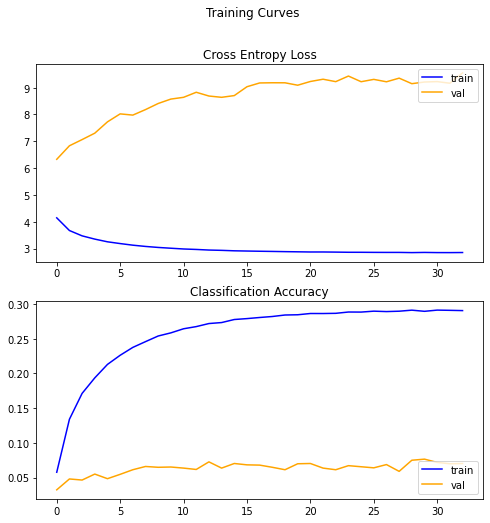


Test set evaluation metrics
1000/1000 [==============================] - 5s 4ms/step - loss: 3.0014 - accuracy: 0.2652
loss: 3.00
accuracy: 0.27


In [ ]:
model_report(SIMPLE_MODEL,SIMPLE_MODEL_history,1000)

## Αριθμός κλάσεων

Σε αυτό το σημείο θα εξετάσουμε την επίδραση που έχει ο αριθμός των κλάσεων του dataset στην μετρική accuracy.

Θα ξαναφορτώσουμε όλο το dataset.Για αυτην την δουλειά ορίζουμε μια συνάρτηση,βάζοντας όλο τον κώδικα που χρησιμοποιήθηκε στο μέρος "Εισαγωγή και επισκόπηση του συνόλου δεδομένων".Ως παράμετρο της συνάρτησης θα ορίσουμε τον αριθμό των κλάσεων που επιθυμούμε.H συνάρτηση επιστρέφει το καινούργιο dataset χωρισμένο σε train, validation και test δεδομένα.Για λόγους οικονομίας χώρου βάζουμε τη συνάρτηση να είναι κρυμμένη.

In [ ]:
#@title load_dataset function

def load_dataset(class_num):

  # helper functions

  # select from from_list elements with index in index_list
  def select_from_list(from_list, index_list):
    filtered_list= [from_list[i] for i in index_list]
    return(filtered_list)

  # append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
  def get_ds_index(unfiliterd_list, target_list):
    index = 0
    filtered_list=[]
    for i_ in unfiliterd_list:
      if i_[0] in target_list:
        filtered_list.append(index)
      index += 1
    return(filtered_list)

  # select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
  def select_classes_number(classes_number = class_num):
    cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
    cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
    cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
    cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
    if classes_number == 20:
      return cifar100_20_classes_url
    elif classes_number == 40:
      return cifar100_40_classes_url
    elif classes_number == 60:
      return cifar100_60_classes_url
    elif classes_number == 80:
      return cifar100_80_classes_url
    else:
      return -1

  # load the entire dataset
  (x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

  # REPLACE WITH YOUR TEAM NUMBER
  team_seed = 68

  # select the number of classes
  cifar100_classes_url = select_classes_number(class_num)

  team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
  CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

  our_index = team_classes.iloc[team_seed,:].values.tolist()
  our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
  train_index = get_ds_index(y_train_all, our_index)
  test_index = get_ds_index(y_test_all, our_index)

  x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
  y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
  x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
  y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

  CLASSES_NUM=len(our_classes)

  # get (train) dataset dimensions
  data_size, img_rows, img_cols, img_channels = x_train_ds.shape

  # set validation set percentage (wrt the training set size)
  validation_percentage = 0.15
  val_size = round(validation_percentage * data_size)

  # Reserve val_size samples for validation and normalize all values
  x_val = x_train_ds[-val_size:]/255
  y_val = y_train_ds[-val_size:]
  x_train = x_train_ds[:-val_size]/255
  y_train = y_train_ds[:-val_size]
  x_test = x_test_ds/255
  y_test = y_test_ds

  return x_train, y_train, x_val, y_val, x_test, y_test


Θα προχωρήσουμε στην εκπαίδευση του δικτύου για 20,40 και 60 κλάσεις.Για 80 κλάσεις το έχουμε ήδη εκπαιδεύσει παραπάνω,συνεπώς η εκ νέου εκπαίδευσή του κρίνεται περιττή.

### 20 Κλάσεις

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(class_num = 20)

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

VGG16_MODEL_20 = init_VGG16_model(True)
VGG16_MODEL_20_history = train_model(VGG16_MODEL_20, 25, 40, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 6s 65ms/step - loss: 4.2994 - accuracy: 0.0851 - val_loss: 2.0182 - val_accuracy: 0.4281
Epoch 2/25
40/40 [==============================] - 2s 59ms/step - loss: 2.2764 - accuracy: 0.3827 - 

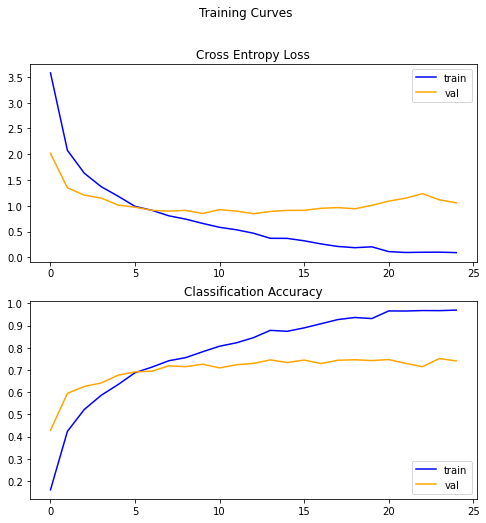


Test set evaluation metrics
28/28 [==============================] - 1s 16ms/step - loss: 1.0939 - accuracy: 0.7467
loss: 1.09
accuracy: 0.75
INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/VGG16_MODEL_20/assets


In [ ]:
model_report(VGG16_MODEL_20, VGG16_MODEL_20_history, 28)
VGG16_MODEL_20.save("drive/My Drive/colab_sessions/VGG16_MODEL_20")

### 40 Κλάσεις

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 4s 67ms/step - loss: 4.5232 - accuracy: 0.0369 - val_loss: 3.1940 - val_accuracy: 0.2070
Epoch 2/25
40/40 [==============================] - 3s 64ms/step - loss: 3.3573 - accuracy: 0.1830 

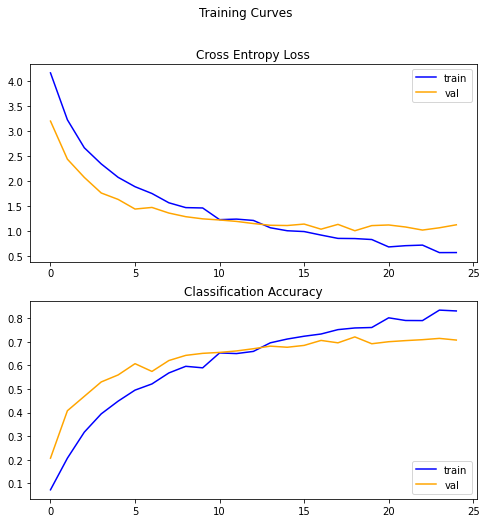


Test set evaluation metrics
28/28 [==============================] - 1s 15ms/step - loss: 1.0656 - accuracy: 0.6970
loss: 1.07
accuracy: 0.70
INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/VGG16_MODEL_40/assets


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(class_num = 40)

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

VGG16_MODEL_40 = init_VGG16_model(True)
VGG16_MODEL_40_history = train_model(VGG16_MODEL_40, 25, 40, 10)

model_report(VGG16_MODEL_40, VGG16_MODEL_40_history, 28)
VGG16_MODEL_40.save("drive/My Drive/colab_sessions/VGG16_MODEL_40")

### 60 Κλάσεις

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 4s 70ms/step - loss: 4.7103 - accuracy: 0.0224 - val_loss: 4.1127 - val_accuracy: 0.1000
Epoch 2/25
40/40 [==============================] - 3s 64ms/step - loss: 4.1684 - accuracy: 0.0706 

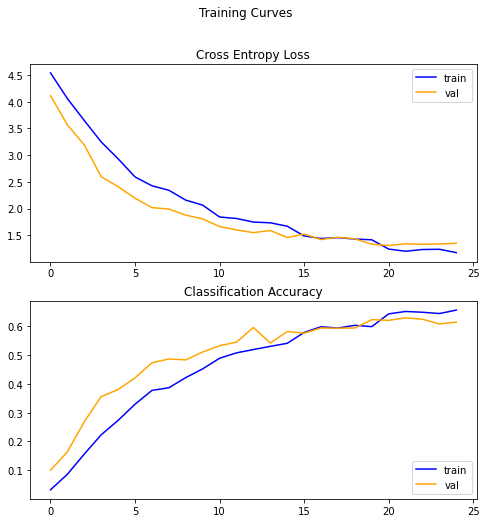


Test set evaluation metrics
28/28 [==============================] - 1s 16ms/step - loss: 1.3313 - accuracy: 0.6211
loss: 1.33
accuracy: 0.62
INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/VGG16_MODEL_60/assets


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(class_num = 60)

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

VGG16_MODEL_60 = init_VGG16_model(True)
VGG16_MODEL_60_history = train_model(VGG16_MODEL_60, 25, 40, 10)

model_report(VGG16_MODEL_60, VGG16_MODEL_60_history, 28)
VGG16_MODEL_60.save("drive/My Drive/colab_sessions/VGG16_MODEL_60")

### 80 κλάσεις

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 6s 74ms/step - loss: 4.8416 - accuracy: 0.0123 - val_loss: 4.5935 - val_accuracy: 0.0234
Epoch 2/25
40/40 [==============================] - 2s 59ms/step - loss: 4.5315 - accuracy: 0.0243 

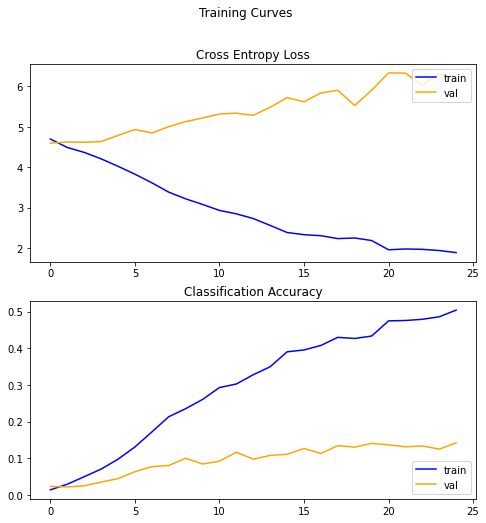


Test set evaluation metrics
28/28 [==============================] - 1s 15ms/step - loss: 1.8141 - accuracy: 0.5061
loss: 1.81
accuracy: 0.51
INFO:tensorflow:Assets written to: drive/My Drive/colab_sessions/VGG16_MODEL_80/assets


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(class_num = 80)

train_ds =_input_fn_8_all(train_path,BATCH_SIZE)
validation_ds =_input_fn_8_all(val_path, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn_8_all(test_path, BATCH_SIZE) #PrefetchDataset object

VGG16_MODEL_80 = init_VGG16_model(True)
VGG16_MODEL_80_history = train_model(VGG16_MODEL_80, 25, 40, 10)

model_report(VGG16_MODEL_80, VGG16_MODEL_80_history, 28)
VGG16_MODEL_80.save("drive/My Drive/colab_sessions/VGG16_MODEL_80")

Παρατηρούμε πως καθώς αυξάνεται ο αριθμός των κλάσεων μειώνεται το accuracy του μοντέλου, συνεπώς το πρόβλημα της ταξινόμησης γίνεται δυσκολότερο.

## Batch Size

Θα πειραματιστούμε με το μέγεθος του batch.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

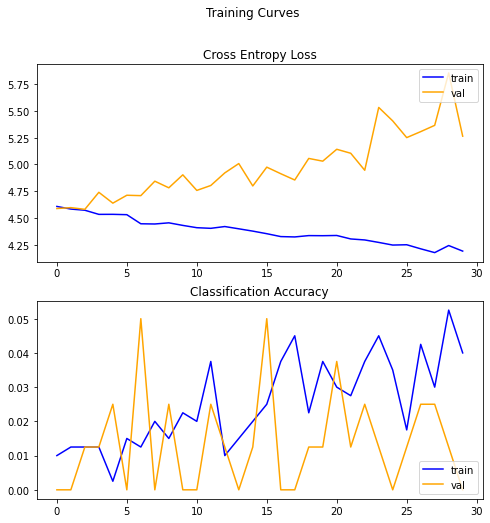


Test set evaluation metrics
30/30 [==============================] - 0s 2ms/step - loss: 4.1766 - accuracy: 0.0667
loss: 4.18
accuracy: 0.07
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)   

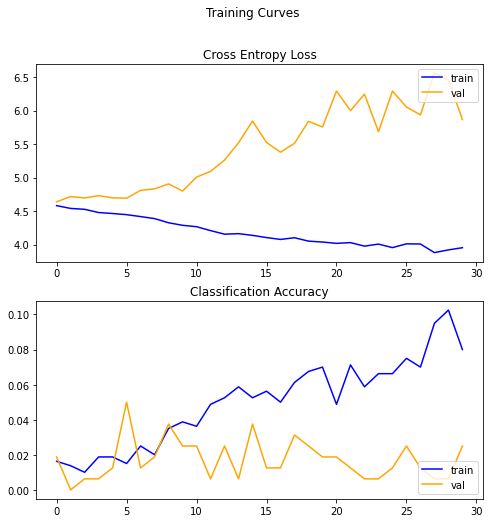


Test set evaluation metrics
30/30 [==============================] - 0s 2ms/step - loss: 3.9557 - accuracy: 0.0625
loss: 3.96
accuracy: 0.06
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)   

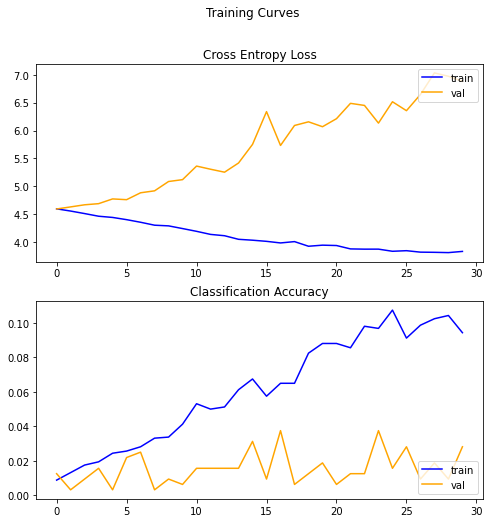


Test set evaluation metrics
30/30 [==============================] - 0s 2ms/step - loss: 3.8030 - accuracy: 0.1187
loss: 3.80
accuracy: 0.12
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)   

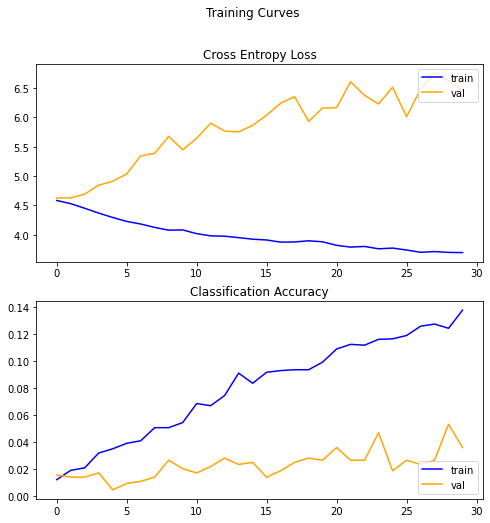


Test set evaluation metrics
30/30 [==============================] - 0s 2ms/step - loss: 3.7022 - accuracy: 0.1271
loss: 3.70
accuracy: 0.13
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)   

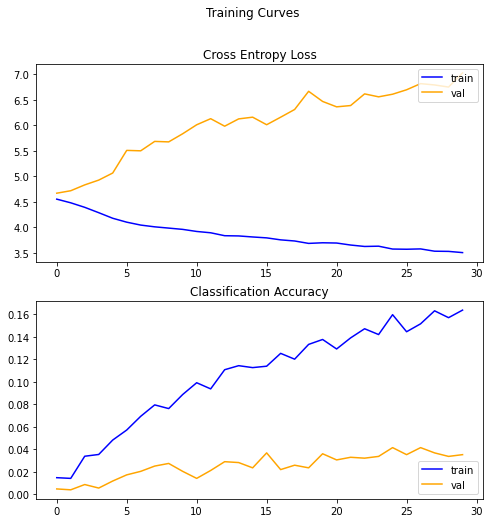


Test set evaluation metrics
30/30 [==============================] - 0s 3ms/step - loss: 3.5541 - accuracy: 0.1672
loss: 3.55
accuracy: 0.17
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)   

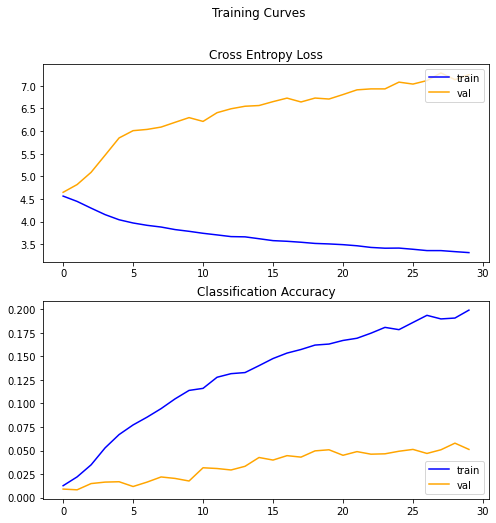


Test set evaluation metrics
30/30 [==============================] - 0s 5ms/step - loss: 3.3871 - accuracy: 0.1883
loss: 3.39
accuracy: 0.19
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)   

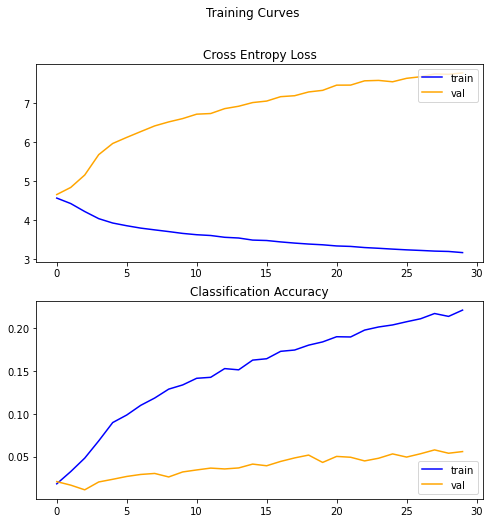


Test set evaluation metrics
30/30 [==============================] - 0s 6ms/step - loss: 3.2336 - accuracy: 0.2091
loss: 3.23
accuracy: 0.21
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)   

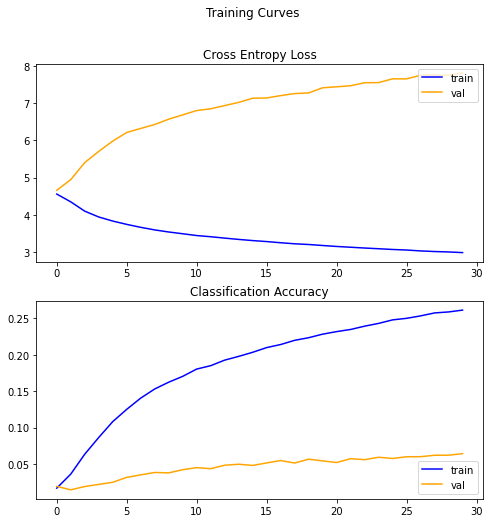


Test set evaluation metrics
30/30 [==============================] - 0s 9ms/step - loss: 3.0953 - accuracy: 0.2421
loss: 3.10
accuracy: 0.24
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)   

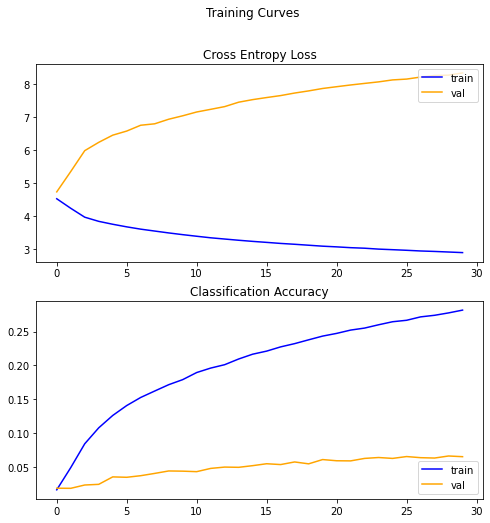


Test set evaluation metrics
30/30 [==============================] - 1s 16ms/step - loss: 3.0297 - accuracy: 0.2534
loss: 3.03
accuracy: 0.25
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)  

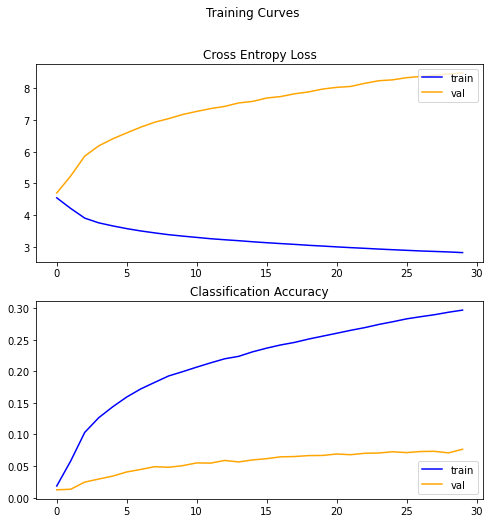


Test set evaluation metrics
30/30 [==============================] - 1s 29ms/step - loss: 2.9636 - accuracy: 0.2714
loss: 2.96
accuracy: 0.27
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024) 

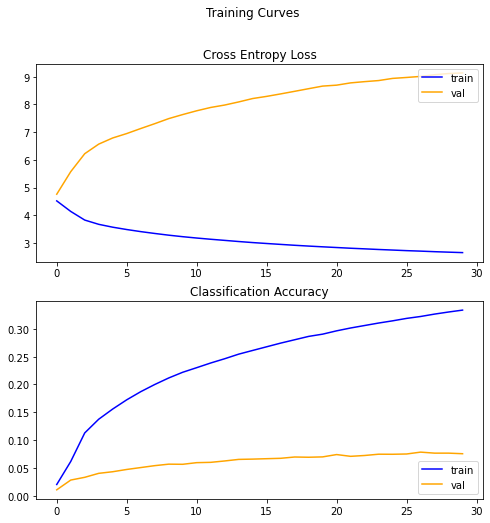


Test set evaluation metrics
30/30 [==============================] - 2s 57ms/step - loss: 2.8392 - accuracy: 0.2995
loss: 2.84
accuracy: 0.30


In [ ]:
for BATCH_SIZE in [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
  train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
  validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
  test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object
  SIMPLE_MODEL = init_simple_model(summary = True)
  %time SIMPLE_MODEL_history = SIMPLE_MODEL.fit(train_ds, epochs=30, steps_per_epoch=100, validation_data=validation_ds, validation_steps=20)
  model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

# Συνδυασμός τεχνικών 

Σε αυτό το κεφάλαιο θα συνδυάσουμε τεχνικές που είδαμε προηγουμένως προσπαθώντας να επιτύχουμε καλύτερα αποτελέσματα.

## Simple model

Θα εκπαιδεύσουμε ξανά το απλό μοντέλο  που μας δώθηκε προσθέτωντας : 
*   Ένα BatchNormalization μετά από κάθε Conv2D layer
*   Dropout layers μετά από τα MaxPooling layers και πριν το τελικό Dense layer
* Αναζήτηση για την τιμή των dropout layers και το μεγεθος του προτελευταίου Dense με το Keras Tuner
*   Data Augmentantion
*   Προσαρμοστικό Learning Rate
*   Μοmentum
* Kernel regularizer σε όλα τα convolutional layers


In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

# Training parameters
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
weight_decay = 0.0005

def init_simple_model_boosted(hp):

  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3),
                          kernel_regularizer=regularizers.l2(weight_decay)))
  # model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(hp.Choice('dropout_rate1', values=[0.1, 0.2, 0.3, 0.4])))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(weight_decay)))
  # model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(hp.Choice('dropout_rate1', values=[0.1, 0.2, 0.3, 0.4])))

  model.add(layers.Conv2D(64, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(weight_decay)))
  # model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(hp.Int('Dense_Number', min_value=50, max_value=1000, step=200)))
  model.add(layers.Dropout(hp.Choice('dropout_rate1', values=[0.1, 0.2, 0.3, 0.4])))

  model.add(layers.Activation('relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  sgd = tf.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, 
                loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  model.summary()
  return model

In [ ]:
!rm -rf ./drive/My Drive/colab_sessions/simple_FINAL

In [ ]:
train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

In [ ]:
tuner2 = RandomSearch(
    init_simple_model_boosted,
    objective='val_accuracy',
    max_trials=1000,
    executions_per_trial=1,
    directory=path+'/simple_FINAL',
    project_name='simple_boosted')

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

INFO:tensorflow:Reloading Oracle from existing project drive/My Drive/colab_sessions/simple_FINAL/simple_boosted/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0       

In [ ]:
tuner2.search_space_summary()
# datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
tuner2.search(x_train,y_train,epochs=15, steps_per_epoch=300, validation_steps=20, 
              validation_data=(x_val,y_val), callbacks=[reduce_lr])

models = tuner2.get_best_models(num_models=4)
tuner2.results_summary()

Trial 14 Complete [00h 00m 24s]
val_accuracy: 0.06816666573286057

Best val_accuracy So Far: 0.06816666573286057
Total elapsed time: 00h 06m 02s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropo

Mετά την αναζήτηση υπερπαραμετρων προχωρούμε στην εκπαίδευση του μοντέλου

In [ ]:
# Training parameters
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
weight_decay = 0.0005

def init_simple_model_boosted(summary):

  model = Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3),
                          kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.1))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.1))

  model.add(layers.Conv2D(64, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(450))
  model.add(layers.Dropout(0.3))

  model.add(layers.Activation('relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  sgd = tf.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, 
                loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if(summary):
    model.summary()
  return model

In [ ]:
SIMPLE_MODEL = init_simple_model_boosted(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 100, 1000, 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)         

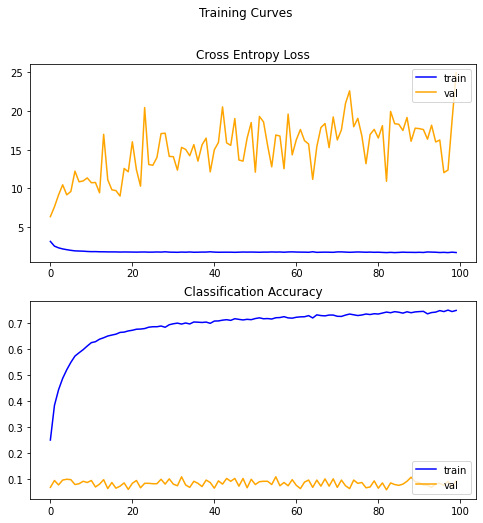


Test set evaluation metrics
30/30 [==============================] - 0s 5ms/step - loss: 9.2074 - accuracy: 0.3094
loss: 9.21
accuracy: 0.31


In [ ]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

Παρακάτω θα προσπαθήσουμε να βελτιώσουμε περαιτέρω το accuracy με data augmentation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(width_shift_range=0.08,height_shift_range=0.08,rotation_range=10,horizontal_flip=True)
generator.fit(x_train)
train_ds = generator.flow(x=x_train,y=y_train,batch_size=64,shuffle=True)

SIMPLE_MODEL = init_simple_model_boosted(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 100, 1000, 15)

Παρατηρήσαμε πως η απόδοση δεν βελτιονόταν,συνεπώς τερματίσαμε την εκτέλεση.Πιθανοί λόγοι της αδυναμίας αύξησης της απόδοσης αναλύονται στο κεφάλαιο "Αποτελέσματα".

## Model 2

Θα εκπαιδεύσουμε ξανά το μοντέλο 2 που ορίστηκε παραπάνω προσθέτωντας : 

*   Data Augmentantion
*   Dropout
*   Προσαρμοστικό Learning Rate
*   Μοmentum

Χρησιμοποιούμε ως optimizer τη στοχαστική κατάβαση κλίσης



In [ ]:
def create_model(summary):
  weight_decay = 0.0005

  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same',
              input_shape=[32,32,3],kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))
  model.add(Dense(100))
  model.add(Activation('softmax'))

  sgd = tf.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

  if summary:
    model.summary()
  return model

In [16]:
# parameters
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
batch_size = 128

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_val = to_categorical(y_val, 100)

In [ ]:
model = create_model(True)
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=200,
                    validation_data=(x_val, y_val),callbacks=[reduce_lr],verbose=1)
model.save_weights(path+'best_model_2.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 64)       

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
265/265 [==============================] - 24s 84ms/step - loss: 21.5936 - accuracy: 0.0182 - val_loss: 18.5041 - val_accuracy: 0.0125
Epoch 2/200
265/265 [==============================] - 22s 84ms/step - loss: 16.0982 - accuracy: 0.0402 - val_loss: 13.3928 - val_accuracy: 0.0132
Epoch 3/200
265/265 [==============================] - 22s 82ms/step - loss: 11.0458 - accuracy: 0.0475 - val_loss: 11.3561 - val_accuracy: 0.0068
Epoch 4/200
265/265 [==============================] - 22s 82ms/step - loss: 8.0909 - accuracy: 0.0643 - val_loss: 8.6535 - val_accuracy: 0.0112
Epoch 5/200
265/265 [==============================] - 22s 83ms/step - loss: 6.3918 - accuracy: 0.0753 - val_loss: 7.5163 - val_accuracy: 0.0132
Epoch 6/200
265/265 [==============================] - 22s 83ms/step - loss: 5.4013 - accuracy: 0.0825 - val_loss: 6.6061 - val_accuracy: 0.0115
Epoch 7/200
265/265 [==============================] - 22s 83ms/step - loss: 4.7509 - accuracy: 0.1044 - val_loss: 6.4214 - 

NameError: ignored

In [ ]:
model.save_weights(path+'best_model_2.h5')

In [ ]:
model2 = create_model(False)
model2.load_weights(path+'best_model_2.h5')

4/4 [==============================] - 1s 196ms/step - loss: 2.3004 - accuracy: 0.6699


[2.3004331588745117, 0.6698750257492065]

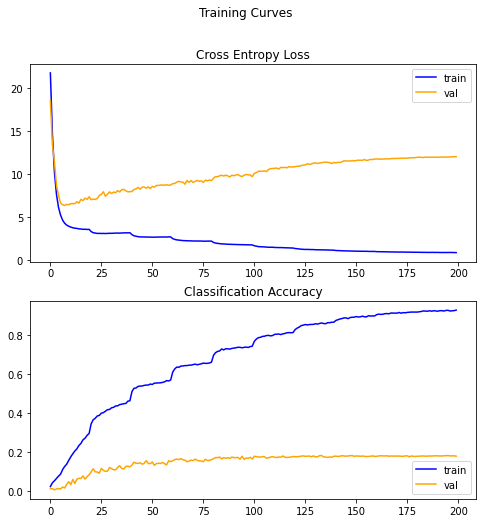

In [ ]:
summarize_diagnostics(hist)
model2.evaluate(x_test, y_test,2000)

Παρατηρούμε μεγάλη βελτίωση, καθώς πριν τη βελτιστοποίηση είχαμε πετύχει accuracy 0.4299 με αυτό το μοντέλο, ενώ τώρα επιτύχαμε 0.6699 στο σύνολο των test δεδομένων. 

Πηγή: [link](https://www.kaggle.com/zaiyankhan/cifar-100)

# Αποτελέσματα Συνοπτικά

Παρακάτω παρουσιάζονται με περιεκτικό/συνοπτικό τρόπο τα αποτελέσματα από όλο το notebook.

## Χρόνος εκτέλεσης

Τα αποτελέσματα αναφέρονται στο μοντέλο "SIMPLE MODEL" που μας δόθηκε από την εκφώνηση για epochs=30, steps_per_epoch=50, validation_steps=20 .

Tεχνική | Χρόνος εκπαίδευσης
--- | ---
Simple        | 9min 42s
Parallel Read | 9min 53s
Parallel Calls| 9min 51s
Parralel Calls optimized | 9min 28s
Caching       | 7min 54s
Caching + Prefetching    | 7min 46s
Eναλλαγή εντολών | 11min 6s
Συνδυασμός τεχνικών - 1 | 7min 52s
Συνδυασμός τεχνικών - 2 | 7min 56s

\\

\\

Σε όλες τις παραπάνω τεχνικές μείωσης του χρόνου εκπαίδευσης έχει γίνει μετατροπή των δεδομένων σε TFRecords.

## Έλεγχος Υπερπροσαρμογής


<table>
<thead>
  <tr>
    <th>Mοντέλο</th>
    <th>Early Stopping</th>
    <th>Dropout</th>
    <th>Data Augmentation</th>
    <th>Epochs / Steps_per_epoch</th>
    <th>Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Simple</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>50 / 200</td>
    <td>0.27</td>
  </tr>
  <tr>
    <td>Simple</td>
    <td>OXI</td>
    <td>NAI</td>
    <td>OXI</td>
    <td>50 / 200</td>
    <td>0.26</td>
  </tr>
  <tr>
    <td>Simple</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>NAI</td>
    <td>50 / 66 </td>
    <td>0.21</td>
  </tr>
  <tr>
    <td>Simple</td>
    <td>NAI</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>15 / 1000</td>
    <td>0.31</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>30 / 1000</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>OXI</td>
    <td>NAI</td>
    <td>OXI</td>
    <td>30 / 1000</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>OXI</td>
    <td>OXI</td>
    <td>NAI</td>
    <td>30 / 1000</td>
    <td>0.78</td>
  </tr>
</tbody>
</table>

Παρατηρούμε πως το απλό μοντέλο δεν έχει βελτίωση χρησιμοποιώντας τεχνικές μείωσης την υπερπροσαρμογής.Αυτό μπορεί να συμβαίνει διότι για τον αριθμό epochs που το εκπαιδεύσαμε δεν πρόλαβε να αποκτήσει σημάδια υπερπροσαρμογής,συνεπώς δεν υπάρχει κάτι για να βελτιώσουμε.Είναι επίσης πιθανό το dataset μας να είναι πολύ μεγάλο για το συγκεκριμένο δίκτυο,συνεπώς η υπερπροσαργμογή είναι εκ κατασκευής μειωμένη. Χρησιμοποιώντας Dropout βλέπουμε τα ίδια αποτελέσματα με το μοντέλο χωρίς τη χρήση του.Η ελάχιστη μείωση μπορεί να οφείλεται σε στοχαστικούς παράγοντες.Αντίθετα, η τεχνική Data Augmentation επιφέρει σημαντική μείωση του accuracy.Το μοντέλο μας είναι πιθανό να μην έχει την απαραίτητη χωρητικότητα για να αποθηκεύσει όλα τα διαφορετικά patterns που του παρουσιάζονται, κάτι που οδηγεί σε μείωση της ορθότητάς του.Το τελευταίο γίνεται καλύτερα κατανοητό παρατηρώντας την σημαντική αύξηση του accuracy στο μοντέλο EfficientNet,το οποίο ειναι πολύ μεγαλύτερο του simple model.Βλέπουμε πως το data augmentation μπορεί να είναι ένα πολύ ισχυρό εργαλείο όταν χρησιμοποιείται σε δίκτυα με αρκετή χωρητικότητα, συγκριτικά πάντα με τον αριθμό των δειγμάτων.   

## Eπίδραση του αριθμού των κλάσεων


<table>
<thead>
  <tr>
    <th>Mοντέλο</th>
    <th>Αριθμός Κλάσεων</th>
    <th>Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>VGG16</td>
    <td>20</td>
    <td>0.75</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>40</td>
    <td>0.70</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>60</td>
    <td>0.62</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>80</td>
    <td>0.51</td>
  </tr>
</tbody>
</table>

\\

Παρατηρούμε πως καθώς αυξάνεται ο αριθμός των κλάσεων μειώνεται το accuracy του μοντέλου, συνεπώς το πρόβλημα της ταξινόμησης γίνεται δυσκολότερο.

## Batch Size

Εκπαιδεύσαμε το simple model για Epochs = 30, steps_per_epoch = 100 και μεταβάλλαμε τον αριθμό του batch.


<table>
<thead>
  <tr>
    <th>Mοντέλο</th>
    <th>Batch Size</th>
    <th>Xρόνος Εκπαίδευσης<br>(sec)</th>
    <th>Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Simple Model</td>
    <td>4</td>
    <td>20.4</td>
    <td>0.07</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>8</td>
    <td>18.1</td>
    <td>0.06</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>16</td>
    <td>18.4</td>
    <td>0.12</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>32</td>
    <td>19.6</td>
    <td>0.13</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>64</td>
    <td>21.9</td>
    <td>0.17</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>128</td>
    <td>28.4</td>
    <td>0.19</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>256</td>
    <td>41</td>
    <td>0.21</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>512</td>
    <td>1min 10s</td>
    <td>0.24</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>1024</td>
    <td>2min 11s</td>
    <td>0.25</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>2048</td>
    <td>3min 57s</td>
    <td>0.27</td>
  </tr>
  <tr>
    <td>Simple Model</td>
    <td>4096</td>
    <td>7min 39s</td>
    <td>0.30</td>
  </tr>
</tbody>
</table>

Παρατηρούμε πως αυξάνεται ο χρόνος εκπαίδευσης, αλλά αυξάνεται και η ορθότητα, πράγμα που περιμέναμε καθώς το δίκτυο εκπαιδεύεται σε περισσότερα δεδομένα, άρα έχουμε "περισσότερη εκπαίδευση".

## Συγκριση Μοντέλων

Συγκρίνουνε του πειραματισμούς που έγιναν κατά τη διάρκεια της άσκησης.Κάποια αποτελέσματα μοντέλων έχουν παραλειφθεί, είτε γιατί ήταν παρεμφερή με κάποια από τα απεικονιζόμενα αποτελέσματα, είτε γιατί κάποια εκδοχή του ίδιου μοντέλου επέφερε καλύτερα αποτελέσματα.




<table>
<thead>
  <tr>
    <th>Mοντέλο</th>
    <th>Early Stopping</th>
    <th>Dropout</th>
    <th>Data Augmentation</th>
    <th>Epochs / Steps_per_epoch</th>
    <th>Parameters</th>
    <th>Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Simple Model</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>100 / 1000</td>
    <td>128,420</td>
    <td>0.27</td>
  </tr>
  <tr>
    <td>Simple Model<br>(οptimized)</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>100 / 1000</td>
    <td>563,310</td>
    <td>0.31</td>
  </tr>
  <tr>
    <td>Our Model 1</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>100 / 30 </td>
    <td>5,195,280</td>
    <td>0.11</td>
  </tr>
  <tr>
    <td>Our Model 1<br>(dropout optimized)</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>50 / 30 </td>
    <td>5,195,280</td>
    <td>0.16</td>
  </tr>
  <tr>
    <td>Our Model 2</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>20 / 1000</td>
    <td>15,047,588</td>
    <td>0.43</td>
  </tr>
  <tr>
    <td>Our Model 2<br>(optimized)</td>
    <td>NO</td>
    <td>YES</td>
    <td>YES</td>
    <td>200 / 265</td>
    <td>15,047,588</td>
    <td>0.67</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>25 / 40 </td>
    <td>14,765,988</td>
    <td>0.49</td>
  </tr>
  <tr>
    <td>ResNet50V2<br>(trainable = False)</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>200 / 40 </td>
    <td>24,667,236</td>
    <td>0.17</td>
  </tr>
  <tr>
    <td>ResNet50V2<br>(trainable = True)</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>50 / 40</td>
    <td>24,667,236</td>
    <td>0.26</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>30 / 1000</td>
    <td>4,177,664</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>NO</td>
    <td>YES</td>
    <td>NO</td>
    <td>30 / 1000</td>
    <td>4,177,664</td>
    <td>0.58</td>
  </tr>
  <tr>
    <td>EfficientNet</td>
    <td>NO</td>
    <td>NO</td>
    <td>YES</td>
    <td>30 / 1000</td>
    <td>4,177,664</td>
    <td>0.78</td>
  </tr>
    <tr>
    <td>BiT-L (R50x3)<br> (pretrained)</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>20 / 1000</td>
    <td>211,174,080</td>
    <td>0.45</td>
  </tr>
  <tr>
    <td>XCeption</td>
    <td>NO</td>
    <td>NO</td>
    <td>NO</td>
    <td>20 / 100</td>
    <td>21,025,400</td>
    <td>0.73</td>
  </tr>
</tbody>
</table>

Απο τα αποτελέσματα βλέπουμε τη σημασία του Transfer Learning.Παρατηρούμε πως τα μοντέλα με την ψηλότερη ορθότητα είναι το EfficientNet και το XCeption.Το 2ο μάλιστα δεν έχει υποστεί καν κάποια βελτιστοποίηση,αλλά απλώς το εκπαιδεύσαμε στα δεδομένα μας.Διαμέσου του transfer learning μας δίνεται η δυνατότητα να χρησιμοποιήσουμε ένα προ-εκπαιδευμένο δίκτυο που κανονικά θα ήταν πολύ δύσκολο να εκπαιδεύσουμε με τους πόρους μας.Επιπλέον, αυτά τα δίκτυα μας βοηθούν στην έρευνά μας, καθώς αποτελούν αρχιτεκτονικές που λειτουργούν με σωστό τρόπο,συνεπώς  παίρνουμε κατευθείαν καλά αποτελέσματα.Αυτό μας γλιτώνει χρόνο από ανούσιους πειραματισμούς και μας οδηγεί προς την κατεύθυνση της βελτιστοποίησης μιας ήδη υπάρχουσας αρχιτεκτονικής.Αυτό ειναι πολύ σημαντικό για φοιτητές σαν εμάς, καθώς θα ήταν αδύνατο να εφεύρουμε ένα τόσο καλό δίκτυο.Συνεπώς πετυχαίνουμε καλύτερα αποτελέσματα,με λιγότερο κόπο και σπαταλώντας σημαντικά λιγότερους πόρους,καθώς συνήθως αυτά τα δίκτυα είναι ογκώδη.

Επίσης από τα αποτελέσματά μας φαίνεται η σημαντικότητα της βελτιστοποίησης υπερπαραμέτρων.Στο simple model αλλάζωντας κάποιες παραμέτρους στο δίκτυό μας ανεβαίνει η ορθότητα χωρίς να χρησιμοποιήσουμε καν επαύξηση δεδομένων,πράγμα που ίσως μείωνε την υπερπροσαρμογή και επέφερε ακόμα καλύτερα αποτελέσματα.Στο "our model 1" η αναζήτηση κάποιων καλών τιμών για το dropout μέσω του keras tuner οδήγησε σε αύξηση της ορθοτητας 5%.Τις πιο εντυπωσιακές αυξήσης παρατηρούμε με τη χρήση του data augmentation.Σε συνδυασμό με άλλες τεχνικές όπως είναι η χρήση kernel_regularizer στα convolutional layers και το adaptive learning rate επιφέρει αύξηση της ορθότητας μέχρι και 24% (Οur Model 2).

Σχετικά με τις τεχνικές που χρησιμοποιήσσαμε,παρατηρήσαμε ελάχιστη έως καθόλου βελτίωση για το early stopping, μικρή βελτίωση για την τεχνική dropout,μικρή βελτίωση για το adaptive learning rate,μεγάλη επίδραση του Data Augmentation, και μικρή έως καθόλου επίδραση για άλλες τεχνικές (όπως πχ η χρήση BatchNormalization layers).Όσον αναφορά τον αριθμό των epochs και το steps_per_epoch, σε γενικές γραμμές ισχύει το "όσο περισσότερο τόσο το καλύτερο" με την αύξησή τους να μεταφράζεται σε αντιστρόφως ανάλογες απολαβές σε αύξηση της ορθότητας.Πρακτικά αυτό σημαίνει πως από έναν αριθμό και πάνω παύουν να συνεισφέρουν σε βελτίωση.Καθώς όλες αυτές οι τεχνικές σε ορισμένες περιπτώσεις βελτίωναν την ορθότητα ενώ σε άλλες δεν επιδρούσαν ή ακόμα και επιδρούσαν αρνητικά,τη μεγαλύτερη βαρύτητα φαίνεται να έχει η βελτιστοποίηση υπερπαραμέτρων.Σε πολλές περιπτώσεις μια τεχνική φαινόταν να μην συνεισφέρει στο τελικό αποτέλεσμα, όμως ύστερα από πειραματισμούς με τις υπερπαραμέτρους τελικά οδηγηθήκαμε σε βελτιωμένα αποτελέσματα. 